# Generate a PPi train + validation set from [APID](http://cicblade.dep.usal.es:8080/APID/init.action) and a Y2H test set from [HuRI](http://www.interactome-atlas.org/download)
## prep

- March 2021 version of [APID](http://cicblade.dep.usal.es:8080/APID/init.action)
- interactomes for the 35 organisms listed as "with more than 500 interactions" only
- some organism datasets will be dropped later, so not fetching smaller sets is ok
- binary interactomes -> Level 2 -> `Q1` suffix
- not using *H. sapiens* for training -> `9606_*Q1.txt`


Preliminary loss from leaving out inter-species PPIs and the human interactome. First the number of IDs, then the number of PPIs:

| APID     |              ISI |            noISI |      loss |
|---------:|:----------------:|:----------------:|:---------:|
| w/ Human | 67'240 : 319'429 | 61'429 : 296'653 | .09 : .07 |
| no Human | 55'014 : 179'349 | 45'026 : 161'598 | .18 : .10 |
|     loss |    .18 : .44     |    .27 : .46     | .33 : .49 |

In [1]:
from __future__ import annotations

import os
import sys
import shutil
import importlib

from pathlib import Path

from dataclasses import dataclass, field
from dataclass_wizard import JSONWizard

Mess around with paths because I'm running this a few times on different system.

In [2]:
!which python
!pwd

/home/k/kaindll/mambaforge/envs/ppi/bin/python
/home/k/kaindll/ppi/data/ppi_dataset/template


In [3]:
if 'kaindl' in str(cwd := Path.cwd()):
    cwd = Path('/home/k/kaindll/ppi/data/ppi_dataset/template')
package_root = str(cwd.parents[2])
if package_root not in sys.path:
    sys.path.append(package_root)
package_root

'/home/k/kaindll/ppi'

In [4]:
session = '7080'
session_dir = cwd.parent / 'results' / session

if not session_dir.is_dir():
    shutil.copytree(cwd, session_dir, symlinks=False,
                    ignore=shutil.ignore_patterns('*.ipynb', '*.png'),
                    dirs_exist_ok=True)
os.chdir(session_dir.resolve())
!pwd

/home/k/kaindll/ppi/data/ppi_dataset/results/7080


In [5]:
from data.utils.cfg import Config, SamplingStrategy
from data.utils import api, extract, general, pairs, plot, reduce, proteome

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

#### config
These are the somewhat relevant settings. Have a look!

In [6]:

@dataclass
class Params(JSONWizard):
    class _(JSONWizard.Meta):
        key_transform_with_dump = 'SNAKE'

    keep_human: bool = False
    keep_interspecies: bool = False
    accept_homodimers: bool = False
    add_proteomes: bool = True
    slurm: bool = all(shutil.which(t) for t in ('snakemake', 'sbatch'))
    slurm_node_limit: int = 15
    rostclust: bool = shutil.which('rostclust')

    min_seq_len: int = 50
    max_seq_len: int = 1500

    seed: int = 42
    ratio: float = 10.0
    strategy: SamplingStrategy = SamplingStrategy.BALANCED

    val_set_size: float = .1
    val_species: Set[str] = field(default_factory=set)


hval_config = dict(shortAlignmentLen=50,
                   longSeqLen=180,
                   reduceRandomAlign=False,
                   clusterThreshold=20)

val_species = {10377, 37296, 9031, 8355, 9913, 7955, 39947, 10116, 36329, 224308}
params = Params()

The detour below is meant to keep the class definition above short, and the `Config` class importable from other modules.

In [7]:
c = Config(
    **params.to_dict() | dict(
        hval_config=hval_config, val_species=val_species,
        cwd=session_dir, strategy=params.strategy
    ))

In [8]:
c.legacy = True

In [9]:
remote = Path('/home/k/kaindll') / Path(*session_dir.parts[4:])


def push():
    !rsync -zar --size-only -e ssh "." "kaindll@lapislazuli:{remote}"


def pull():
    !rsync -zar --size-only -e ssh "kaindll@lapislazuli:{remote}/" "."


c.rostclust, remote

('/home/k/kaindll/mambaforge/envs/ppi/bin/rostclust',
 PosixPath('/home/k/kaindll/ppi/data/ppi_dataset/results/7080'))

#### importlib
For development, it's nice to be able to edit the imported modules.

## Toy example
#### bias of negative dataset

In [10]:
# demonstrate sampling strategies: toy PPI table example
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK'''
ppis = ppis_from_string(raw)
ppi_dict = dict()
ppis

,0,1
0,A,B
1,A,C
2,C,F
3,A,E
4,K,L
5,C,K
6,B,G
7,G,M
8,A,O
9,E,O


In [11]:
ppi_dict['balanced'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42, strategy=SamplingStrategy.BALANCED))
# balanced sampling tries to conserve the distribution of degrees -> high-bias dataset

In [12]:
ppi_dict['random'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42, strategy=SamplingStrategy.RANDOM))
# random sampling gives a nearly un-biased dataset

In [13]:
ppi_dict['complement'], *_ = find_negative_pairs(
    ppis, Config(ratio=10, seed=42, strategy=SamplingStrategy.BALANCED))
# sampling the entire network complement will perfectly invert the degree distribution

#### strategies visualized
It becomes apparent that the combination of graph size and density is important, and that random or balanced sampling generate different sets of negatives.

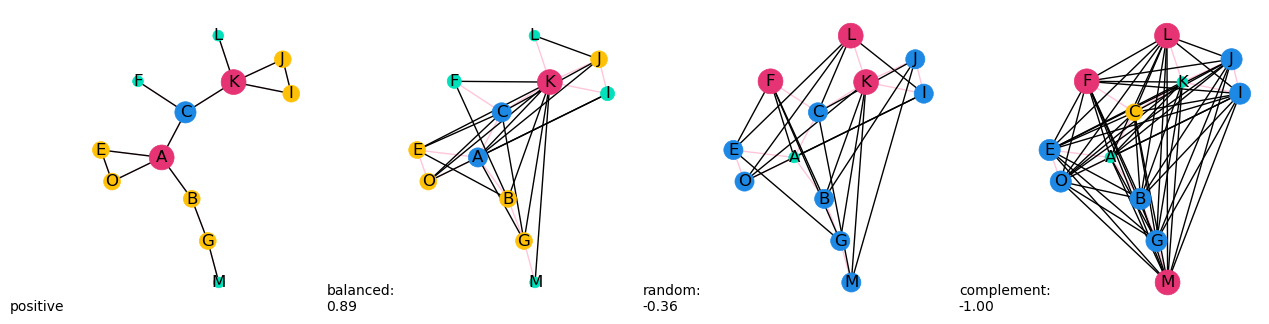

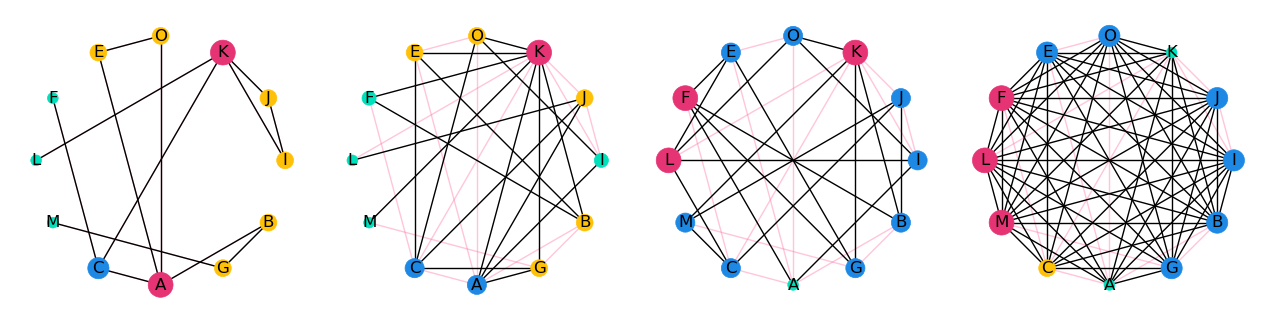

In [15]:
_ = draw_toy_ppis(ppis, ppi_dict)

#### with homodimers

In [16]:
# added F-F
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK\nF\tF'''
ppis = ppis_from_string(raw)

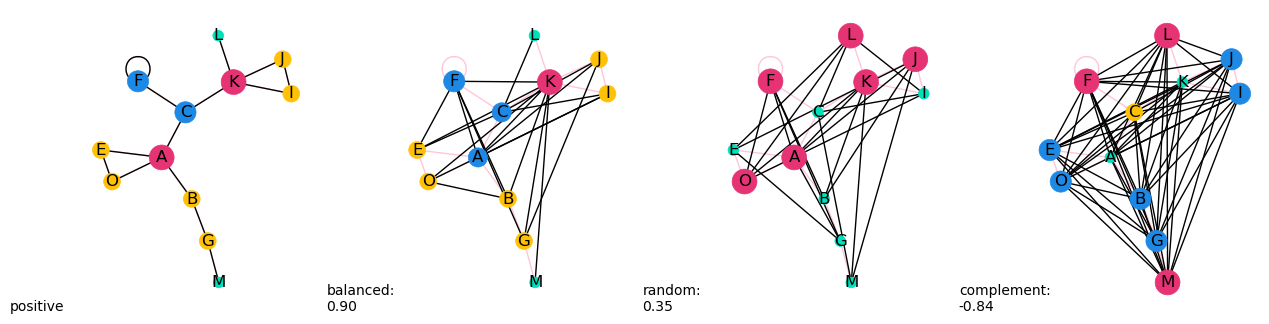

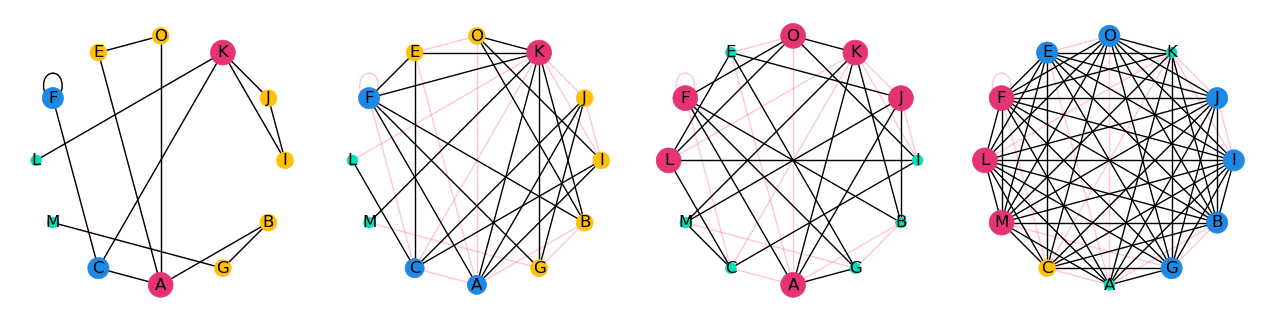

In [17]:
ppi_dict = dict()
ppi_dict['balanced'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42, strategy=SamplingStrategy.BALANCED))
ppi_dict['random'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42, strategy=SamplingStrategy.RANDOM))
ppi_dict['complement'], *_ = find_negative_pairs(
    ppis, Config(ratio=10, seed=42, strategy=SamplingStrategy.BALANCED))
_ = draw_toy_ppis(ppis, ppi_dict)

#### input homodimers, but not allowed as negatives

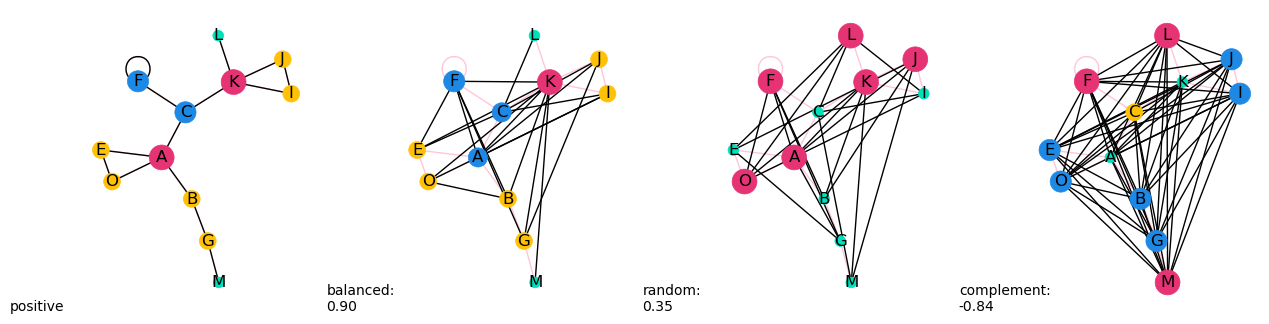

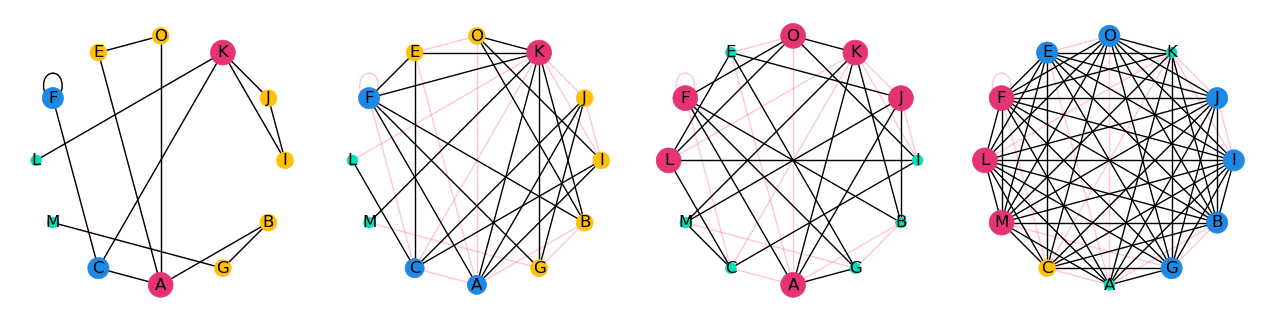

In [18]:
ppi_dict = dict()
ppi_dict['balanced'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42,
                 strategy=SamplingStrategy.BALANCED,
                 accept_homodimers=False))
ppi_dict['random'], *_ = find_negative_pairs(
    ppis, Config(ratio=1.5, seed=42,
                 strategy=SamplingStrategy.RANDOM,
                 accept_homodimers=False))
ppi_dict['complement'], *_ = find_negative_pairs(
    ppis, Config(ratio=10, seed=42,
                 strategy=SamplingStrategy.BALANCED,
                 accept_homodimers=False))
_ = draw_toy_ppis(ppis, ppi_dict)

## Train set: APID
#### extract from `<taxid>*_Q1.txt` files

In [19]:
c.qp = unzip_apid(zip_path='apid.zip', keep_human=c.keep_human,
                  keep_interspecies=c.keep_interspecies)
c.qp

PosixPath('apid_q1')

In [20]:
uniprot_ids = extract_apid_uniprot_ids(c.qp)
len(uniprot_ids)

45026

In [21]:
ppis = extract_apid_ppis(c.qp)
len(ppis)

161598

In [22]:
ppis.head()

,UniprotID_A,UniprotID_B,species
0,P04591,P04591,11706
1,P04585,P04585,11706
2,P04618,P04618,11706
0,Q10113,Q1MTQ1,284812
1,P87027,Q10951,284812


#### interspecies interactions
Check if there are PPIs (based on UniProt IDs) that occur in several species. We use APID `noISI` data per default, so the exclusion of this data is not implemented.

In [23]:
find_multi_species_ppis(ppis)

,UniprotID_A,UniprotID_B,species


In [24]:
# proof that actually worked: add some dummy data
for i in [0, 1]:
    s = ppis.iloc[i].copy()
s.species = 'marsupilami'
ppis = pd.concat([ppis, pd.DataFrame(s).T], axis=0)

marsu = find_multi_species_ppis(ppis)

# drop the dummy data
ppis = ppis.loc[ppis.species != 'marsupilami']
marsu

,UniprotID_A,UniprotID_B,species
1,P04585,P04585,11706
1,P04585,P04585,marsupilami


or more generally protein IDs that occur in several species:

In [26]:
find_multi_species_proteins(ppis)

,UniprotID,species


#### download sequences

In [ ]:
# skip if re-running this w/o changes above or deleting files
_ = uniprot_api_fetch(uniprot_ids, c.ap / 'apid')

#### map IDs to seq hashes

In [27]:
hash_ppis = ppis_to_hashes(ppis, c.ap / 'apid.json').drop_duplicates()
hash_ppis.head()

,hash_A,hash_B,species
3,CRC-48F409F4E28F37BE,CRC-9AC87796A0BA67D9,632
1,CRC-4A7DEB955583CB27,CRC-6D6C1B4ED5C94EC7,632
0,CRC-5E21543540EBF92B,CRC-8561A9A0C1A2E169,632
2,CRC-8049DCC1A80C7391,CRC-9AC87796A0BA67D9,632
4,CRC-9AC87796A0BA67D9,CRC-9AC87796A0BA67D9,632


In [28]:
len(ppis) - len(hash_ppis)

1030

In [29]:
fasta = SeqIO.to_dict(SeqIO.parse(c.ap / 'apid.hash.fasta', 'fasta'))
len(fasta)

44707

#### filter by seq length

In [30]:
c.min_seq_len, c.max_seq_len

(50, 1500)

dropped 9425/160568 PPIs from length filtering
dropped 0/42505 table IDs and 0/151143 rows, and 2202/44707 sequence IDs


(44707, 42505)

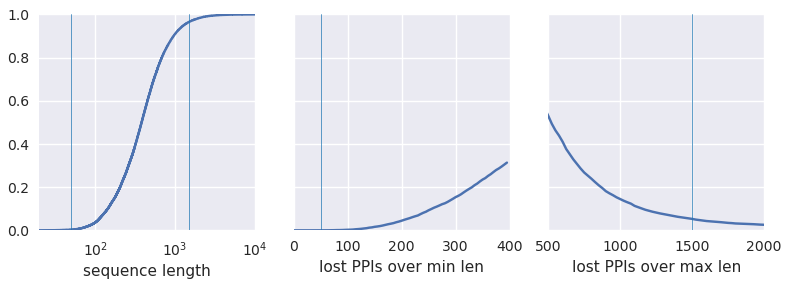

In [31]:
_hash_ppis, _fasta, _ = filter_ppis_and_fasta_by_len(
    hash_ppis, fasta, c.min_seq_len, c.max_seq_len)
len(fasta), len(_fasta)

continue if these limits were ok, or change/set the values for
`cfg.min_seq_len, cfg.max_seq_len` and re-run the filtering cell

In [32]:
hash_ppis = _hash_ppis
fasta = _fasta

#### homodimer share
Overall count, share, overall PPI count

(False, 4249, 0.0281, 151143)

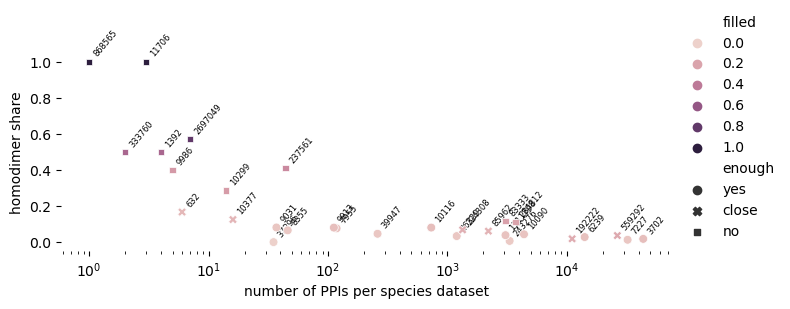

In [33]:
_ = plot_homodimer_share(hash_ppis)
c.accept_homodimers, *count_homodimers(hash_ppis),

In [34]:
if not c.accept_homodimers:
    hash_ppis = drop_homodimers(hash_ppis)
hash_ppis, fasta = shrink_both_ways(hash_ppis, fasta)
len(hash_ppis), len(fasta)

dropped 0/42053 table IDs and 0/146894 rows, and 452/42505 sequence IDs


(146894, 42053)

#### species lookup

In [35]:
# pick not just viruses for validation!
taxonomy = fetch_taxonomic_info(hash_ppis.species).sort_values(by='n_ppis')
taxonomy

100%|████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.11it/s]


,species,name,n_ppis
24,333760,Human papillomavirus type 16,1
1,1392,Bacillus anthracis,2
27,2697049,Severe acute respiratory syndrome coronavirus 2,3
9,9986,Oryctolagus cuniculus,3
0,632,Yersinia pestis,5
12,10299,Human alphaherpesvirus 1 strain 17,10
13,10377,Human herpesvirus 4 strain B95-8,14
21,237561,Candida albicans SC5314,26
7,9031,Gallus gallus,34
15,37296,Human gammaherpesvirus 8,35


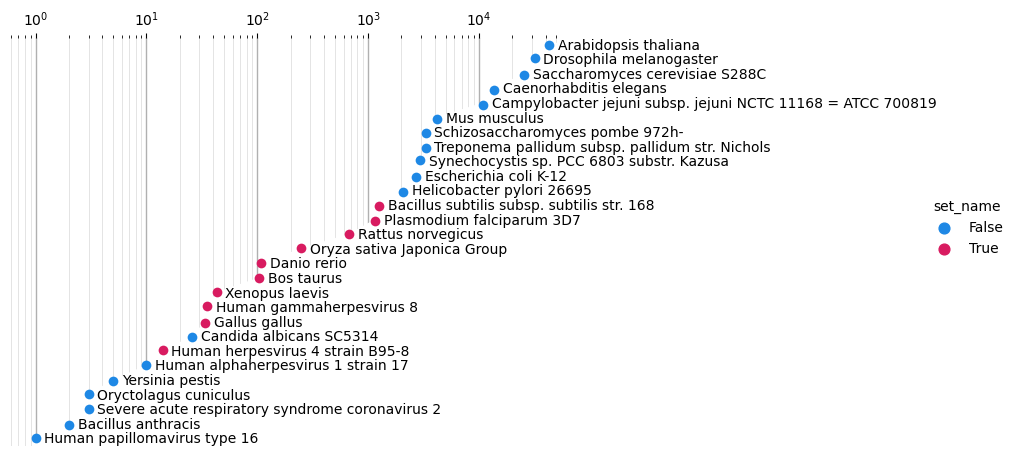

In [36]:
_ = plot_interactome_sizes(taxonomy, c.val_species)

#### download proteomes

In [37]:
# # skip if re-running this w/o changes above or deleting files
# if c.add_proteomes:
#     fetch_proteomes(set(taxonomy.species) | {9606}, c.pp)
#     filter_proteomes_by_len(c.pp, c.min_seq_len, c.max_seq_len)

## Validation set: APID
#### val: select species/proteins
Either by sampling a subset of proteins and selecting the PPIs or picking the ones for one or more particular species

In [38]:
c.val_set_size, c.val_species

(0.1, {7955, 8355, 9031, 9913, 10116, 10377, 36329, 37296, 39947, 224308})

In [39]:
taxonomy.loc[taxonomy.species.isin(c.val_species)]

,species,name,n_ppis
13,10377,Human herpesvirus 4 strain B95-8,14
7,9031,Gallus gallus,34
15,37296,Human gammaherpesvirus 8,35
6,8355,Xenopus laevis,43
8,9913,Bos taurus,103
5,7955,Danio rerio,109
16,39947,Oryza sativa Japonica Group,248
11,10116,Rattus norvegicus,673
14,36329,Plasmodium falciparum 3D7,1156
20,224308,Bacillus subtilis subsp. subtilis str. 168,1247


In [40]:
hash_ppis['label'] = 1
if c.val_species is not None:
    train, val = make_validation_species(hash_ppis, c.val_species)
else:
    # if the set becomes too large, try another seed!
    # With this approach, PPIs *will* be lost
    train, val = make_validation_split(hash_ppis, c.val_set_size, c.seed)
c.val_species = set(val.species)
c.train_species = set(train.species)
len(train), len(train) / len(hash_ppis), len(val), len(val) / len(hash_ppis)

(143232, 0.975070458970414, 3554, 0.024194316990482932)

In [41]:
val.head()

,hash_A,hash_B,species,minlen,maxlen,label
122,CRC-000BC5DD420D0669,CRC-2808F51BBD3A8B6E,7955,264,363,1
19,CRC-0B5D3548EEF911AE,CRC-F5A8EAFC27AD733E,7955,574,940,1
65,CRC-0E6AE7E0F9C5520F,CRC-3C5E4EDDF27EACFF,7955,424,999,1
20,CRC-12077214EFED46D0,CRC-F5A8EAFC27AD733E,7955,558,940,1
85,CRC-12A7DE26809AAAF4,CRC-DAB541D403215A02,7955,169,1030,1


In [42]:
val.species.unique(), train.species.unique()

(array([  7955,   8355,   9031,   9913,  10116,  10377,  36329,  37296,
         39947, 224308]),
 array([    632,    1392,    3702,    6239,    7227,    9986,   10090,
          10299,   83333,   85962,  192222,  237561,  243276,  284812,
         333760,  559292, 1111708, 2697049]))

Separate the validation set sequences from the ones remaining as train set

#### train: save seqs + positives


In [43]:
_, train_seqs = shrink_both_ways(train.copy(), fasta.copy())
c.train_seqs = len(train_seqs)
len(train_seqs), len(fasta)

dropped 0/39429 table IDs and 0/143232 rows, and 2624/42053 sequence IDs


(39429, 42053)

In [44]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_raw_fasta, 'fasta')
train.to_csv(c.train_raw_tsv, sep='\t', header=True, index=False)
c.train_raw_fasta, c.train_raw_tsv

(PosixPath('apid/apid_train_raw.fasta'), PosixPath('apid/apid_train_raw.tsv'))

#### val: save seqs + positives

In [45]:
_, val_seqs = shrink_both_ways(val.copy(), fasta.copy())
len(val_seqs), len(fasta)

dropped 0/2601 table IDs and 0/3554 rows, and 39452/42053 sequence IDs


(2601, 42053)

In [46]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_raw_fasta, 'fasta')
val.to_csv(c.val_raw_tsv, sep='\t', header=True, index=False)
c.val_raw_fasta, c.val_raw_tsv

(PosixPath('apid/apid_validation_raw.fasta'),
 PosixPath('apid/apid_validation_raw.tsv'))

Mind that the TSVs will contain only positives! Sample negatives only after most of the `uniqueprot`-shebang.

## Test set: HuRI
#### download and extract PPIs

In [47]:
c.psi_path

PosixPath('hi_union.psi')

In [48]:
# it's somehow a lot faster to download this from a browser!
# or run !wget "http://www.interactome-atlas.org/data/HI-union.psi" -O "hi_union.psi"
download_y2h_interactome(c.psi_path)

already downloaded and SHA256 checks out


PosixPath('hi_union.psi')

In [49]:
huri_ppis, huri_seq_ids = extract_huri_ppis(c.psi_path)
len(huri_ppis)

97888

In [50]:
huri_seqs, _ = fetch_huri_seqs(huri_seq_ids, c.hp / 'huri')
len(huri_seqs)

loading from huri/huri.hash.fasta and huri/huri.json


9119

#### map + filter PPIs

In [51]:
print(set(huri_ppis.species))  # only human, but keep the label
huri_ppis.head()

{9606}


,0,1,species
0,P0DP25,A0A087WXN0,9606
1,Q68D86-1,Q9HD26-2,9606
2,Q13515,Q9UJW9,9606
3,P30049,Q05519-2,9606
4,ENSP00000462298,P43220,9606


In [52]:
# some 35K protein IDs point to the same sequence
huri_hash_ppis = ppis_to_hashes(huri_ppis, c.hp / 'huri.json')
len(huri_ppis), len(huri_ppis) - len(huri_hash_ppis), len(huri_hash_ppis)

(97888, 35329, 62559)

In [53]:
huri_hash_ppis.head()

,hash_A,hash_B,species
22905,CRC-000037AE195F7A9D,CRC-82152E496B924EEC,9606
143452,CRC-000624825E507385,CRC-C116E348E8B7AD2B,9606
62304,CRC-000624825E507385,CRC-D7C7F6F2CD922775,9606
7538,CRC-000CFE2B83394B42,CRC-40C7C3686632F6A7,9606
27848,CRC-0012F055C7F2A233,CRC-2E96FD0179EE119D,9606


In [54]:
# make sure we don't test on sequences that we trained on; A LOT more checks later
huri_hash_ppis = remove_ids_from(huri_hash_ppis, black_list_fasta=c.train_raw_fasta)
len(huri_hash_ppis)

61208

In [55]:
*count_homodimers(huri_hash_ppis), c.accept_homodimers

(752, 0.0123, 61208, False)

In [56]:
if not c.accept_homodimers:
    huri_hash_ppis = drop_homodimers(huri_hash_ppis)
huri_hash_ppis, huri_seqs = shrink_both_ways(huri_hash_ppis, huri_seqs)
len(huri_hash_ppis), len(huri_seqs)

dropped 0/8953 table IDs and 0/60456 rows, and 166/9119 sequence IDs


(60456, 8953)

dropped 1205/60456 PPIs from length filtering
dropped 0/8773 table IDs and 0/59251 rows, and 180/8953 sequence IDs


(8953, 8773)

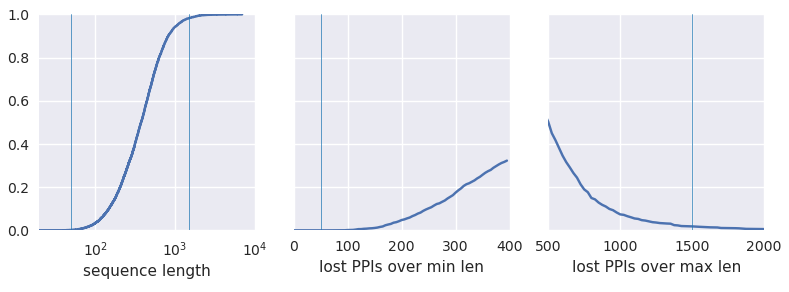

In [57]:
_huri_hash_ppis, _huri_seqs, fig = filter_ppis_and_fasta_by_len(
    huri_hash_ppis, huri_seqs, c.min_seq_len, c.max_seq_len)
len(huri_seqs), len(_huri_seqs)

#### test: save seqs + positives

In [58]:
huri_hash_ppis = _huri_hash_ppis
huri_seqs = _huri_seqs

In [59]:
_ = SeqIO.write(huri_seqs.values(), c.test_raw_fasta, 'fasta')
huri_hash_ppis.to_csv(c.test_raw_tsv, sep='\t', header=True, index=False)
c.test_raw_fasta, c.test_raw_tsv

(PosixPath('huri/huri_test_raw.fasta'), PosixPath('huri/huri_test_raw.tsv'))

## Test + validation: redundancy-reduce

Use [rostclust](https://git.rostlab.org/bernhoferm/mmseqs2-uniqueprot/-/tree/F_typer_app) to create non-redundant `test` and `validation` sets. <br> Don't run the next cells in the wrong order, and don't forget to copy the files back and forth if you are running `rostclust` elsewhere! <br>In particular, copy files after `shrink_files_both_ways`.

In [60]:
c.hval_config

{'shortAlignmentLen': 50,
 'longSeqLen': 180,
 'reduceRandomAlign': False,
 'clusterThreshold': 20}

In [61]:
with c.hval_config_path.open('w') as json_file:
    json_file.write(json.dumps(hval_config, indent=4))

The flag below allows me to test this notebook without the MMseqs2 runs. Leave `rostclust` at `False` and copy the two result files to this folder; or run `rostclust uniqueprot[2D]` now and here.

In [62]:
c.rostclust

'/home/k/kaindll/mambaforge/envs/ppi/bin/rostclust'

In [ ]:
# redundancy-reduce the test set
run_uniqueprot(c.test_raw_fasta, c.test_rr_fasta,
               c.hval_config_path, not c.rostclust)

In [ ]:
# and validation
run_uniqueprot(c.val_raw_fasta, c.val_rr_fasta,
               c.hval_config_path, not c.rostclust)

In [63]:
fastalen = lambda _file: len([r.id for r in SeqIO.parse(_file, 'fasta')])

In [64]:
# also drop PPIs accordingly
assert c.test_rr_fasta.is_file()
shrink_files_both_ways(c.test_raw_tsv, c.test_rr_fasta,
                       new_tsv_name=c.test_rr_tsv)
c.test_seqs = fastalen(c.test_rr_fasta)
assert c.val_rr_fasta.is_file()
shrink_files_both_ways(c.val_raw_tsv, c.val_rr_fasta,
                       new_tsv_name=c.val_rr_tsv)
c.val_seqs = fastalen(c.val_rr_fasta)

dropped 3635/8773 table IDs and 36101/59251 rows, and 0/5138 sequence IDs
dropped 855/2601 table IDs and 1270/3554 rows, and 0/1746 sequence IDs


dropped 3635/8773 table IDs and 36101/59251 rows, and 0/5138 sequence IDs
dropped 855/2601 table IDs and 1270/3554 rows, and 0/1746 sequence IDs

## Prepare proteomes

In [65]:
# if not c.add_proteomes:
#     raise NotImplementedError('Please manually skip ahead!')

#### run separately: faster
Separately clustering the proteomes against the test/validation set and then redundancy-reducing each one is faster and might lead to a more balanced combined proteome set that is better fit to sample from than merging all proteomes first and then running the two steps on huge files.

If available, run this on a SLURM cluster:

In [66]:
c.slurm, c.slurm_node_limit

(True, 15)

In [ ]:
if c.slurm:
    import snakemake

    snakemake.snakemake(snakefile='Snakefile',
                        config=c.to_dict() | dict(pkg_root=package_root),
                        nodes=c.slurm_node_limit,
                        cluster=f'sbatch -p All -N 1')

#### train: cluster against val
Mind that `train_species` and `val_species` may overlap! We deal with that later.

In [67]:
s = None
if not c.slurm:
    s = rr_pattern_proteomes(
        c.train_species, c.pp, '{sp}.fasta', 'val',
        c.val_rr_fasta, c.hval_config_path, not c.rostclust)
s

#### train: cluster against test

In [68]:
if not c.slurm:
    s = rr_pattern_proteomes(
        c.train_species, c.pp, '{sp}_nr_val.fasta', 'valtest',
        c.test_rr_fasta, c.hval_config_path, not c.rostclust)
s

These `_nr_valtest.fasta` proteomes are now ready to be used as negatives for the train set!

#### val: cluster against val

In [69]:
if not c.slurm:
    # this is the same as the first call, just for different files!
    s = rr_pattern_proteomes(
        c.val_species, c.pp, '{sp}.fasta', 'val',
        c.val_rr_fasta, c.hval_config_path, not c.rostclust)
s

#### val: redundancy-reduce

In [70]:
if not c.slurm:
    # now a 1D run -> no database/reference FASTA
    s = rr_pattern_proteomes(
        c.val_species, c.pp, '{sp}_nr_val.fasta', 'val',
        None, c.hval_config_path, not c.rostclust)
s

#### val: merge

In [71]:
val_concat = c.pp / 'val_proteome_concat.fasta'
val_concat_rr = val_concat.with_stem(val_concat.stem + '_rr')

In [75]:
merge_pattern_proteomes(c.val_species, val_concat, c.pp, '{sp}_rr_val.fasta')

#### val: redundancy-reduce merged set

In [ ]:
run_uniqueprot(val_concat, val_concat_rr, c.hval_config_path, not c.rostclust)

#### test: cluster against test

In [76]:
if not c.slurm:
    s = run_uniqueprot2D(c.pp / '9606.fasta',
                         c.test_rr_fasta,
                         c.pp / '9606_nr_test.fasta',
                         c.hval_config_path, not c.rostclust)
s

#### test: redundancy-reduce

In [77]:
if not c.slurm:
    s = run_uniqueprot(c.pp / '9606_nr_test.fasta', c.pp / '9606_rr_test.fasta',
                       c.hval_config_path, not c.rostclust)
s

The `swissprot/9606_rr_test.fasta` can be used as test set negatives directly; as this is a single-species set there is no combined set that needs redundancy reduction.

#### collate train/val/test proteomes
Create per-species dicts of potential negative interaction partners. Doing this once to save some `pull` calls.

In [78]:
train_proteome = write_json(read_hash_proteomes(
    c.train_species, c.pp, '{sp}_nr_valtest.fasta'), c.train_proteome)

100%|██████████████████████████████████| 18/18 [00:26<00:00,  1.45s/it, batch=2.7e+6]


In [79]:
val_proteome = write_json(parse_val_proteome(val_concat_rr), c.val_proteome)

50379it [00:06, 7726.64it/s] 


In [80]:
test_proteome = write_json(read_hash_proteomes(
    {9606}, c.pp, '{sp}_rr_test.fasta'), c.test_proteome)

100%|██████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it, batch=9606]


## Generate negatives: examples
Negatives are sampled *per species*. Mind that the test set is human-only!
Start with the train set!
Re-write with proteomes, but without C123 labels.

In [81]:
c.strategy, c.ratio, c.seed, c.accept_homodimers

(<SamplingStrategy.BALANCED: 1>, 10.0, 42, False)

In [82]:
train_proteome = read_json(c.train_proteome)

In [83]:
train.head()

,hash_A,hash_B,species,minlen,maxlen,label
3,CRC-48F409F4E28F37BE,CRC-9AC87796A0BA67D9,632,170,833,1
1,CRC-4A7DEB955583CB27,CRC-6D6C1B4ED5C94EC7,632,266,334,1
0,CRC-5E21543540EBF92B,CRC-8561A9A0C1A2E169,632,95,326,1
2,CRC-8049DCC1A80C7391,CRC-9AC87796A0BA67D9,632,170,258,1
5,CRC-BED64D5961AA5E38,CRC-D4C3706260D2937A,632,207,780,1


In [84]:
train.species.value_counts().rename('n_ppis')

3702       42794
7227       31832
559292     25498
6239       13694
192222     10863
10090       4186
284812      3302
243276      3294
1111708     2944
83333       2707
85962       2068
237561        26
10299         10
632            5
9986           3
2697049        3
1392           2
333760         1
Name: n_ppis, dtype: int64

#### tiny examples

10299: 10 positives, aim for 100 negatives


10299: 234it [00:00, 8088.90it/s]                                                    

10299: 83/100 interactome negatives
10299: need 18 extra proteins for 4 hubs; select 28 from 55/71 (new/available) SwissProt proteins. Try to create 34 interactions, ideally 1.25 per protein.
10299: CRC-1CECA86CF1B9F2FF:CRC-38FF9C5DD831BFDB:CRC-8CF9D73C6313FAE9:CRC-A50C0AB9FB9AA3F0:CRC-BE8271E5B7E34776:CRC-8CF33C769092BB5F:CRC-961A133FE7A30CA7:CRC-94D56376545B1192:CRC-D4FE0FD98D934C46:CRC-CFE8868BAA86F616:CRC-39381B1D6B5F08C8:CRC-3A32E059B7DA3E92:CRC-EEBBF813B97EF4B8:CRC-1A9EAD88C2B54331:CRC-7B86C941A0105035:CRC-3F8F0B7C122B2E36:CRC-FDA96829D742912D:CRC-DF38A1C539DAB15C:CRC-4F32E04C95CA9344:CRC-5128181FBF08DA50:CRC-94B52171F355F6FC:CRC-F7FDC2867E834B92:CRC-58479A4B7255F3BA:CRC-CED51D2FC1D7777F:CRC-9F58D7D18ABFA5A7:CRC-D6D48868B4323C5A:CRC-E08FD792409A81E6:CRC-12D01B0E7C920EA3
proteome interactions:
   count  mean   std  min  25%  50%  75%  max
0   21.0  1.62  0.59  1.0  1.0  2.0  2.0  3.0
10299: got 117 negatives with bias 0.996


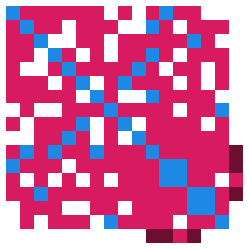

In [85]:
if 10299 in c.train_species:
    with mpl.rc_context({'figure.dpi': 64}):
        _ = make_negatives(train.loc[train.species == 10299].copy(), c, train_proteome)

237561: 26 positives, aim for 260 negatives


237561: 552it [00:00, 11227.39it/s]                                                  


237561: 244/260 interactome negatives
237561: need 19 extra proteins for 4 hubs; select 25 from 5034/5061 (new/available) SwissProt proteins. Try to create 32 interactions, ideally 1.3 per protein.
237561: CRC-C8D7915D1E407877:CRC-1EF9AD5F967F95AF:CRC-F6249A5C5D7FC795:CRC-973C93EF50A56738:CRC-72346EBA6473C56C:CRC-E0115CB31AB1D23B:CRC-2F4D37A2127A7253:CRC-A1D452A5706F853A:CRC-79F3ACB8446D36AF:CRC-EE2C13FF229F2BCA:CRC-1F26321EB5F56F7D:CRC-F04A1927D3AC99EF:CRC-C5255628FE612D45:CRC-7E54EDBC43AD588A:CRC-7A453B25C4C10D67:CRC-19E5494F3F938D8C:CRC-CCBCD4BDE09E0EE6:CRC-5283ACEF748CEACB:CRC-00BA56A34B881EC5:CRC-15FB606643D7A79F:CRC-FC6BD4FF9CD4C68B:CRC-211E72852FBE29A5:CRC-2B318B6019979570:CRC-30A4796C4C7B0160:CRC-91DD72D7536F8529
proteome interactions:
   count  mean  std  min  25%  50%  75%  max
0   21.0  1.52  0.6  1.0  1.0  1.0  2.0  3.0
237561: got 276 negatives with bias 0.997


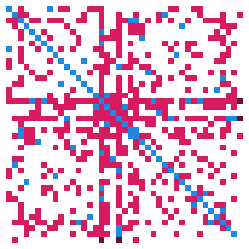

In [86]:
with mpl.rc_context({'figure.dpi': 64}):
    t_ppis, t_negs, t_bias, _ = make_negatives(
        train.loc[train.species == 237561].copy(), c, train_proteome)

In this symmectric adjacency matrix, true PPIs and interactions that are not allowed as negatives are shown in blue. This often includes the diagonal; homodimers. Selected negatives are in red. The last row/column indicates *wanted* interactions that could not be satisfied in the existing set; with darker/lighter red indicating more than one extra interaction for the protein in that row/column. These extra negative interaction partners were drawn from SwissProt proteomes.

#### small example

#### multi-species example

#### tests from APID train

In this example, the number of available negatives falls far short of the target. The adjacency matrix is completely filled; and each protein would *should* get more than one extra negative interaction partner. However, we see that only 7 proteins in the non-redundant SwissProt proteome for this species were not already in the given set of PPIs, and we would actually need 30 to generate negatives at the target ratio.

## APID train
#### generate negatives

In [87]:
# sanity check if there are any proteins in test that
# were already in train. re: "do not add back in identical ones"
assert not ({r.id for r in SeqIO.parse(c.train_raw_fasta, 'fasta')} & {
    r.id for r in SeqIO.parse(c.test_rr_fasta, 'fasta')})

In [88]:
train_ppis, train_negs, train_bias, _ = make_negatives(train, c, train_proteome)

sampling negatives per species! aim for 1432320


632:   0%|                                                   | 0/100 [00:00<?, ?it/s]

632: 138it [00:00, 10775.45it/s]                                                     


632: CRC-D3099C81447845AB:CRC-67B3323D6BEB8690:CRC-A64A03235E3FE2E1:CRC-28C1FE238823338A:CRC-BC0F4A93FD174792:CRC-C8CAEBFDA04536E6:CRC-B7F0EE1190302522:CRC-2D604459A91F1947:CRC-E968731F8121AB42:CRC-9225637DB2E5EDB7:CRC-E44D6196463879F2:CRC-97A486AD3525D987:CRC-9D34F564AAC716C1:CRC-0C369688908E0758:CRC-F65588CCC12CBD1F:CRC-FDA67B2DE0326FCC:CRC-23F484385F199985:CRC-F533619EF0617567:CRC-F675A2FEAA0E3592:CRC-25EB03D9B0088C44:CRC-5AEB992DD3C7BC57:CRC-79372C24B854E136:CRC-3ECE328BD9E60F8F:CRC-967BA65CB591C50D:CRC-2541CF3D542345E6:CRC-8C0B493C919ED349:CRC-005598334D268BBF:CRC-2ECAAB267758BF92:CRC-995D140BB5E37B97:CRC-C8661799F5DBEC49:CRC-76F186AEFA04B1D1:CRC-98A2D9D6B004E5BF:CRC-2839E04D3BF7748B:CRC-049D3634918133A8:CRC-6B8A6E674CD4593E


1392: 72it [00:00, 7909.22it/s]                                                      


1392: CRC-ECF34297B38B0307:CRC-20E7C752B5202876:CRC-473CC677A4120011:CRC-FFE7740BC4043355:CRC-F823D8B510A2D75E:CRC-E3B4F467618CD791:CRC-D54B398D3DFC6823:CRC-88B6E090EDFB510B:CRC-57309BCEF72616DF:CRC-209BF5E622F0E2BB:CRC-A994EE739691126B:CRC-709D16B9CB6B2C4C:CRC-99C7A64A60345A6B:CRC-18B1037ABD709452:CRC-7A936F8B74B20B3B:CRC-1514CA4673553D04:CRC-3884CEC343D5E9A6:CRC-A86D0D685BED07E7:CRC-74EF82A16F9D3958:CRC-026B2B9FA77F0A61:CRC-054F9DD6BD844DEA:CRC-DAC55B6FBE881D75:CRC-043C59906D4271C6:CRC-7EBE9041DABB65BA:CRC-74E008DFC66DD021:CRC-94A8A6F250D747FD:CRC-AAD4333AEBFF34BD:CRC-B35BA440B0C11DC9:CRC-2775CC7FDAA8A1D5:CRC-B2D3D34D9E3CD47D:CRC-F1B357D4598153C9:CRC-716F21DB64CFE274

9986: 96it [00:00, 12409.18it/s]                                                     
10299:   0%|                                                 | 0/200 [00:00<?, ?it/s]


9986: CRC-5FB9C991CBA8684B:CRC-1E5A81E61E553E55:CRC-1BEAD02B1AFF4053:CRC-D0E534322A5EDE2F:CRC-7FA833472DBBB51A:CRC-7C7436C93BB4B425:CRC-CB2B4A99647F4769:CRC-0A459008B480B4F4:CRC-8D903388187E5B43:CRC-20B6F5D215C1E2FD:CRC-48A7173A0B249FA1:CRC-1E9877AEB23DF0A0:CRC-B44CCDD8D2604183:CRC-3A15C599EDA57AA4:CRC-75502A99E4203E03:CRC-A106C3D5232B06ED:CRC-B83ED8DB48877B07:CRC-0D0DF10BE100962C:CRC-8F580FEE55D4D9D8:CRC-E454D06521883C67:CRC-280A6E01629F1DB3:CRC-6B9BE4F6FCA80F80:CRC-74BFFAC68B283810:CRC-99CB11F6AC3BE0DE:CRC-0C31FD215E5F1DFB:CRC-4C75C71AA7A5EF3D:CRC-4185128BA97BE42C:CRC-D4E6B9DC11A9DDE9:CRC-6C72B0CEA0B21ABF:CRC-1C7A8FF9C061464B:CRC-067699EC18AD0C52:CRC-F4FC6F2B80D88651:CRC-50FA78CD5EC77FCD:CRC-0BF9C3A1D798426A:CRC-0726749C286275CC:CRC-FA62D0C57EF7679A

10299: 234it [00:00, 11077.51it/s]                                                   


10299: CRC-1CECA86CF1B9F2FF:CRC-38FF9C5DD831BFDB:CRC-8CF9D73C6313FAE9:CRC-A50C0AB9FB9AA3F0:CRC-BE8271E5B7E34776:CRC-8CF33C769092BB5F:CRC-961A133FE7A30CA7:CRC-94D56376545B1192:CRC-D4FE0FD98D934C46:CRC-CFE8868BAA86F616:CRC-39381B1D6B5F08C8:CRC-3A32E059B7DA3E92:CRC-EEBBF813B97EF4B8:CRC-1A9EAD88C2B54331:CRC-7B86C941A0105035:CRC-3F8F0B7C122B2E36:CRC-FDA96829D742912D:CRC-DF38A1C539DAB15C:CRC-4F32E04C95CA9344:CRC-5128181FBF08DA50:CRC-94B52171F355F6FC:CRC-F7FDC2867E834B92:CRC-58479A4B7255F3BA:CRC-CED51D2FC1D7777F:CRC-9F58D7D18ABFA5A7:CRC-D6D48868B4323C5A:CRC-E08FD792409A81E6:CRC-12D01B0E7C920EA3

85962:   0%|                                               | 0/41360 [00:00<?, ?it/s]

333760: 40it [00:00, 4059.33it/s]                                                    
284812:   0%|                                              | 0/66040 [00:00<?, ?it/s]

333760: 0/10 interactome negatives


237561: 552it [00:00, 7686.54it/s]                                                   

333760: CRC-A361364C880D5D78:CRC-442C0ABF0D77CDCF:CRC-BFF1A9F53AFF63A6:CRC-01FEF5ADCFDB37EB:CRC-9BD612534CD2C9EB:CRC-D426CEC3DCE6B0E2:CRC-18E64E793D760744



85962:   1%|▎                                  | 442/41360 [00:00<00:09, 4404.59it/s]

237561: CRC-C8D7915D1E407877:CRC-1EF9AD5F967F95AF:CRC-F6249A5C5D7FC795:CRC-973C93EF50A56738:CRC-72346EBA6473C56C:CRC-E0115CB31AB1D23B:CRC-2F4D37A2127A7253:CRC-A1D452A5706F853A:CRC-79F3ACB8446D36AF:CRC-EE2C13FF229F2BCA:CRC-1F26321EB5F56F7D:CRC-F04A1927D3AC99EF:CRC-C5255628FE612D45:CRC-7E54EDBC43AD588A:CRC-7A453B25C4C10D67:CRC-19E5494F3F938D8C:CRC-CCBCD4BDE09E0EE6:CRC-5283ACEF748CEACB:CRC-00BA56A34B881EC5:CRC-15FB606643D7A79F:CRC-FC6BD4FF9CD4C68B:CRC-211E72852FBE29A5:CRC-2B318B6019979570:CRC-30A4796C4C7B0160:CRC-91DD72D7536F8529


2697049: 114it [00:00, 10199.68it/s]                                                 
6239:   0%|                                   | 300/273880 [00:00<03:27, 1321.27it/s]

2697049: CRC-B17BE6D9F1C4EA34:CRC-1897EBA96E8004E3:CRC-ED44D84C3BB9A6DB:CRC-891E7EAB9E8A5BA9:CRC-8CCDEF1C0EA37D06:CRC-912AD9E147A64907:CRC-B21BD303F59A1D0A

10090:   0%|                                   | 232/83720 [00:00<00:36, 2306.43it/s]

85962: 41546it [00:10, 4146.10it/s]          | 30044/54140 [00:10<00:09, 2675.72it/s]
559292:   2%|▋                              | 11612/509960 [00:09<07:45, 1070.28it/s]

85962: CRC-07D7E1A63048EF48:CRC-FC368C83B7749C36:CRC-B2A699866011E957:CRC-8C3C413A35D9FE83:CRC-E1E6E5457EFA9674:CRC-4FFDF3021F8E4046:CRC-DDCA656FA3C793AD:CRC-7DE21BC84D69DA9E:CRC-35DBDB0C72E74CF7:CRC-7DA8CE3CB8A2374A:CRC-D535F0384B228B44:CRC-CED503D6271FB3A0:CRC-731C02B2EB7C815A:CRC-90AECC4D1048191D:CRC-3F849E05B1A92DA0:CRC-9712F596E48A7E43:CRC-8F4EC7349C93CC91:CRC-B2A8187B3B65849F:CRC-BB5571BC3974DB17:CRC-961AE42B404BBAD1:CRC-888ED21BE7FE7BD3:CRC-4F094021567EFD58:CRC-912B987A6ADA0653:CRC-2FD836C1301CD8A7:CRC-67990182E4A53FB3:CRC-2AC111B9575C3F88:CRC-DF0A3DB00C8C0E66:CRC-D77DD2A388BC184F:CRC-01D8542F2DBF90C8:CRC-AB1034A614740A3E:CRC-9086E51C8FE4E58E:CRC-68DAFF6865BF49E8:CRC-EAB498035188B794:CRC-B53A63F499C6556B:CRC-141FCC128B6D7DE4:CRC-977516175192A188:CRC-CC43C53FC41B39A9:CRC-3F7993A35674B9AF:CRC-C103D5A7FAD42F63:CRC-1BF7B35A9F29A91A:CRC-3754B5858632CF12:CRC-74D7DA9681BAB200:CRC-CAA7CC2302E35CA7:CRC-9FD355E0B19C2DBE:CRC-45114A56C2809C3C:CRC-E09183155E00F4C1:CRC-E74716D64957AD50:CRC-C6

243276: 82330it [00:17, 4681.16it/s]███████▎ | 51376/54140 [00:17<00:00, 2812.61it/s]
284812:  70%|██████████████████████▎         | 46124/66040 [00:17<00:07, 2633.39it/s]

243276: CRC-164311053632B047:CRC-C7B322DDDA598712:CRC-5BB9C80BB334B48A:CRC-3B930B6BBE57EE40:CRC-F238BDAFD5C6D6D7:CRC-C7DD4D3B9FB0C2AD:CRC-426D08D3A0C1B0FB:CRC-CC5025ACD9AB63AE:CRC-994341CD8813F722:CRC-288BE5E35151CB0A:CRC-60B7C9F61BF48959:CRC-65A2CB82B3822EE6:CRC-4AF5160D09371C5C:CRC-37BCD5E6DE950C7D:CRC-00D697BAED537F8C:CRC-3B9F10A428D87882:CRC-2E936EF48A223A2E:CRC-7FF7623F5A963216:CRC-AB21F8A07A88F691:CRC-CC1ADEC6A1C4E3C8:CRC-DEF69003CD6C61AD:CRC-D46BF01CA02B1A56:CRC-37835B6BCABFD6F2:CRC-DC5421F06AEA95CD:CRC-8C7C72BD0C515B6A:CRC-A8A06E3C3F508706:CRC-2DCC799AE3F38C4C:CRC-205E2377076F36B3:CRC-6228CE8DFDFBB206:CRC-FC96B074C7E69CD4:CRC-8919FF3F7052F51F:CRC-41709507D12B3548:CRC-330A58CB5A026955:CRC-F015A9B091840FBA:CRC-82FFC723A01396ED:CRC-561451F2BE54DE11:CRC-0AFFB53157A4D369:CRC-C3B1767960C6C840:CRC-1BBA56BBA07A6319:CRC-9BFABCF00C0E5876:CRC-B5C2A75D4A8849E0:CRC-841938DD82627DC3:CRC-074482F285CC13B8:CRC-DEBE3440CB6D7999:CRC-39EB5D6EEAE1846A:CRC-D498555F71A22D23:CRC-CF53459F1BE76D7D:CRC-9

83333: 54168it [00:18, 2915.58it/s]                                                  
192222:  29%|████████▉                      | 62638/217260 [00:18<00:45, 3425.79it/s]

83333: CRC-CA01ACE48D9CA8DB:CRC-F3188171DDC23918:CRC-D5093A630073020A:CRC-A688AD32AA60F218:CRC-FC3032D13764A869:CRC-88C397FC3D3DC17E:CRC-1749F512C5A2BA16:CRC-28B46455FABA59CF:CRC-440825C334FFF2C9


1111708: 58882it [00:21, 2708.45it/s]                                                
6239:  10%|███▎                             | 27014/273880 [00:22<03:24, 1206.91it/s]

1111708: CRC-E8C7CE696FF78022


284812: 69498it [00:25, 2725.47it/s]        | 32072/273880 [00:25<02:41, 1498.78it/s]
559292:   6%|█▊                             | 29996/509960 [00:25<06:16, 1275.57it/s]

284812: CRC-F14519C995884687:CRC-B900D1F77327C2A6:CRC-A4506291CC21867F:CRC-75A24F261AAF0CE6:CRC-D9B4947CFE2889D7:CRC-A5A7BFA649381114:CRC-95BD16F1879B0D20:CRC-E7935A592DB2BFDA:CRC-33BFED69BFFB0FAF:CRC-22597CE8E5AF9B5F:CRC-B7B9268CB9A6A8B7:CRC-80E1A404253574E3:CRC-88E00C2BDAE4B9BF:CRC-1E2802CC76819573:CRC-612DE3D3F7B64027:CRC-C0ED03E73532A4AA:CRC-F44661005266A678:CRC-BEF42C2B494B7910:CRC-099005F2FD2CCD03:CRC-1D9B44AD7757A111:CRC-E1040C37445A6D36:CRC-9BC90C709E47BC91:CRC-B075514E2F9FDC63:CRC-33EEA6794DBC6A82:CRC-1AD813B4B5D39346:CRC-CCE63830E9B83981:CRC-1A3E82E5D9E40D50:CRC-D6CFFBF3945C5036:CRC-F48EAFF8BB6B234A:CRC-E6202802E0EFF514:CRC-14571B4B6105C76E:CRC-1E62CEA7A724254F:CRC-C0A1727AD6B179AF:CRC-E4230ADD9ABA6077:CRC-6ECC74F169DA747B:CRC-6B16D5152E4252AA:CRC-06A73775D80946B0:CRC-6CD0BA622DDA3CAA:CRC-AA9B5E90A64BF241:CRC-4A2586D0D72A55CE:CRC-E9F81C96B9DA193B:CRC-A0F612C27E8DEF1F:CRC-9240CA34D35786FC:CRC-DD7BE0D143D70C6E:CRC-048629FABB6BB49E:CRC-B540B6671B9AFE11:CRC-6AE6D74B11DCCB36:CRC-6

10090: 84438it [00:40, 2083.05it/s]        | 151222/217260 [00:40<00:14, 4507.91it/s]
559292:  10%|███▏                           | 51486/509960 [00:40<06:17, 1213.44it/s]

10090: CRC-EA313ED0782260F4:CRC-176F67CCF4802B84:CRC-B4A666ED942B258F:CRC-D176AAF8D5A06D34:CRC-BC7A17CAFA830379:CRC-4E5A257C5C9C1CE7:CRC-54ECD2E1DBDB57EA:CRC-23BBE41118199874:CRC-5CE4DD4C2E7C1734:CRC-D6FAC50B7E365194:CRC-B2834C3AD499A57A:CRC-5A2A861EE1A2DEC3:CRC-CEC2867F44AF0E7B:CRC-869F6B0EE01EDF31:CRC-FDFF94F9A616DF98:CRC-64FC1E9BF230E0EA:CRC-F7BE6BEE482939BA:CRC-EEF6175FD6F44B4B:CRC-20A602003218AD49:CRC-E0C09D8DE65D0E54:CRC-287F8D2012875B15:CRC-913CC7A93BF56B45:CRC-686ED8E60D0FA498:CRC-8B9D304A5E8AFD6E:CRC-471D83C532E85A55:CRC-AA0EC1BF9DB0DE8D:CRC-F8755C45CB05D626:CRC-A6574CC61067A4C4:CRC-1E7408543E4A53CF:CRC-6F09A5C80A5B2306:CRC-3CE1C8BA356D87B9:CRC-16821E06A19F3EC2:CRC-816C2068230B36E0:CRC-87D8E242FDBB18F3:CRC-DA295FC7EAB281D6:CRC-65ACF483800BBF3A:CRC-E5BD3E2D1248ACED:CRC-4140DB77A4CE7BE6:CRC-C4FC78C5C3CA7D8B:CRC-778268073E3EFD30:CRC-B3492DEBA1F9AD83:CRC-33E4FDA501AEC4FA:CRC-E72DAC9B4F4E3AD9:CRC-B8918A5A7E938AC4:CRC-B73F082E7C486D39:CRC-7977734EAD6C5BF3:CRC-8790E9F299108140:CRC-28

192222: 241908it [01:00, 4021.70it/s]       | 82888/509960 [00:59<04:23, 1619.83it/s]
559292:  16%|█████                          | 83054/509960 [01:00<04:22, 1626.30it/s]

192222: CRC-80FB500C91AB05A3:CRC-ECAB85E4F4FD6BDD:CRC-490D9FDB4EB58322:CRC-11EF49DE6FD277BB:CRC-682DCB4ABF1FC062:CRC-B9D5F22DD72DBB3B:CRC-9F684BAB4262050D:CRC-0244E98A5099ABCD:CRC-16B81F235DD5F6A6:CRC-949BABB91D863F58:CRC-1A9FF9EE9CE64F6A:CRC-68CBC47CB2B445A3:CRC-C59E926BF87C660E:CRC-770DE65901EE5009:CRC-F571EA5A2B60A8B7:CRC-CDEE191BB13BA141:CRC-53B350CF1C4BA4F7:CRC-3C562051EBC638B4:CRC-4AA0DDB40B61679C:CRC-D463C86466C26685:CRC-8F5C1C5DCF48289F:CRC-B4E3BE3AD6A6A268:CRC-172591D316E08764:CRC-E4AFF7E20CA44C37:CRC-AA2BAEDEBDB73733:CRC-DD44C777F86D0CFA:CRC-D20A0E57E9EE36B8:CRC-3E1D50537C8DD88B:CRC-E3C297B488155FA2:CRC-3E0E73D8C5722A53:CRC-022005EDA20BE4C4:CRC-FF9B49EA0C4C04AD:CRC-3DFF4CD29A5B08C3:CRC-6FD4F2250C44E2EC:CRC-C74454C14D7ABEC4:CRC-B2CFB612DAD0D9DA:CRC-152C211084C6675B:CRC-989109875920A302:CRC-D95CCE0B0CC18643:CRC-C9A7C8D841BD2D98:CRC-0792CF8A37E69965:CRC-DA641A017EE9272F:CRC-8F7A5426DA4E14F5:CRC-401DCA1FC86D0FA3:CRC-07D4D69A756A605B:CRC-217B808012F69292:CRC-3E6178CE236B28A6:CRC-D

6239: 275254it [02:46, 1652.76it/s]        | 175514/636640 [02:46<07:04, 1087.40it/s]
7227:  28%|████████▊                       | 175740/636640 [02:46<06:56, 1106.73it/s]

6239: CRC-076F7C75B145F115:CRC-B0E05D77D01F01CB:CRC-BD114D8C97241BF3:CRC-17B5C1A61BFC1252:CRC-892594DC6DD46EC0:CRC-BF773DB8B24255EB:CRC-7546684A2BC37495:CRC-4E2AA9E74CBF77EC:CRC-79C6347FFDCC7D93:CRC-557EFEA588F84B74:CRC-A3071EB3564294D0:CRC-4412145539FD21C5:CRC-5E8A11D98E9D1F56:CRC-71997BE77F88A0EB:CRC-80053D7118819487:CRC-FDB992CC92C7FD12:CRC-73730982C8B0C5D4:CRC-55C7551AD9A26102:CRC-507D01AC014C945A:CRC-B6B3703192BD024E:CRC-85F890E08DE5EC6F:CRC-D9F9A0B1D885D339:CRC-5D4108B1657319E1:CRC-C6623ED97AAE94DE:CRC-EE2211CED153C7A2:CRC-899FBBEEC4ED8DA2:CRC-C6C5B83EE89452C8:CRC-FE4DCAAA98ECF064:CRC-226FB6E79105BA60:CRC-F1711D1792B9182E:CRC-CAD797FAD0E4CFA3:CRC-9EB1472F7F741E6F:CRC-64001AF9EA41AF59:CRC-CF16A937B826B5E7:CRC-D86306D79F1E30B1:CRC-02C122D1D9256064:CRC-7654B93BE623B5E1:CRC-3C3E9EB12856C620:CRC-C2075079EF1C5FE8:CRC-DE178552F3329DBF:CRC-516FEE8A6AF7FD5F:CRC-1E6C6A2D38C5AF46:CRC-A49A5E76F7F8CD9D:CRC-DB60F49A6AFD0B7F:CRC-86FE72F2E3BDE841:CRC-69C200938234896E:CRC-A25CD04A4D8179EA:CRC-55E

559292: 512904it [05:14, 1630.16it/s]      | 345526/636640 [05:14<04:08, 1172.74it/s]
7227:  54%|█████████████████▍              | 345880/636640 [05:15<04:08, 1168.09it/s]

559292: CRC-4124EDE383E8D539:CRC-C409FA9444671CF2:CRC-C408F169737E9736:CRC-48787C43B10A828E:CRC-45E2FD1514FF0713:CRC-05051CAA4A049CBC:CRC-573418F7ED7DC0A3:CRC-9D8DEB51F6891216:CRC-BFB64B6F36416A5A:CRC-141ABF6A01B008ED:CRC-39EF2082AAE6B8BF:CRC-91820156E72B1EDD:CRC-9A7BAECE97318AFA:CRC-A1CBFF3B98C8CFAA:CRC-B757F0834524E2C2:CRC-6CAD2EE5A6080D9C:CRC-020AB4FAC4B32500:CRC-9AA6B1D12A0C35E8:CRC-F1A61BEB96AE063F:CRC-9507BC4B655950FF:CRC-86BB0238BFA914F1:CRC-733AF5208D555F7E:CRC-FB345DD6EC86319B:CRC-F65B24D48459F745:CRC-F0B74ABC3A4983AD:CRC-7847234CDE01B377:CRC-BCFBA27D22AC6212:CRC-D8309EFC128DD722:CRC-C26A35A844F2841C:CRC-862705A8C789AA6C:CRC-F23EE19603FEC87E:CRC-F5FBA3246A328ABF:CRC-020A56745DF52CCC:CRC-E026E09DB0443C45:CRC-99E0320D0B4DCFA5:CRC-FFD0BD1CB35205A4:CRC-AC15C35ED49E5DE0:CRC-BC8C729FE61EE297:CRC-A46A0E6BC53BF205:CRC-4ECC438FF199B5A0:CRC-551B6EF3BC8E3D4C:CRC-6C17841176EADC1F:CRC-0DE7F985B52319E6:CRC-78C51F15158E54B3:CRC-3246DD5DCE54A868:CRC-7376D1467779B000:CRC-1E4F4A7D22284389:CRC-7

7227: 636696it [09:16, 1143.91it/s]                                                  
3702:  70%|██████████████████████▌         | 602918/855880 [09:17<03:42, 1137.10it/s]

7227: CRC-26E264D218A5BAB9:CRC-9CBAC0FC8E8CE3A8:CRC-EC54D21CC522FC93:CRC-DC9BCD8624C7B623:CRC-24F8745541F646FD:CRC-B442E16CC027D849:CRC-49D1DC76AA7BA32D:CRC-95C7322FAAAF9989:CRC-280249B07FB4BD27:CRC-8D09BD6B0F0DF208:CRC-A36B0568B16C811F:CRC-DDF01A355F0A81DA:CRC-8C8FE1076BFDAE3B:CRC-616C8BDEA4D4DADB:CRC-3A814550009945A9:CRC-0C5614E7970882C6:CRC-43242070656DE708:CRC-AA473C4A5D7170FD:CRC-AE416783D0CE8403:CRC-437D27507C76E93A:CRC-1ABEAE11CB1218C2:CRC-A8C67AF653105852:CRC-D7BCA1270840055C:CRC-7D8B20445B024D18:CRC-AE1E5A97E79E502B:CRC-1D0E450581FCA461:CRC-8F2DA6F9A8E12323:CRC-5DE0610D7604F7FE:CRC-3C9428E9B6ED446E:CRC-970950DA4E816810:CRC-CD4DB0EC3EC81F72:CRC-2AF882894CD47B3D:CRC-D53D2B2006CB45CE:CRC-6755AA5823F04A4B:CRC-05F1296C1E5E6001:CRC-5E2FF61832FFD0CC:CRC-B08F13BF0338369C:CRC-73E18D294CB012FB:CRC-48DB42F94DFDBBA1:CRC-3B4AD003CD59CAA5:CRC-D203ABB57E6DFD30:CRC-397D450166AAC88A:CRC-44FA2CB1176D2104:CRC-46038883DBE647C7:CRC-108794B66CE180C0:CRC-55174D063F6BFE24:CRC-66ABE4A2EA9206C9:CRC-0CD

3702: 866296it [13:02, 1107.21it/s]                                                  


3702: CRC-86D4C8F031948CDC:CRC-6507DBE2F2195AC7:CRC-CC3C01F85BAC25E0:CRC-DC1BD28DABE38DD6:CRC-2C2B52C83CB32BA3:CRC-785C00E42DFE0254:CRC-8CED3FF1491A9043:CRC-449FC1D6ED2D9162:CRC-C3E8B2C4433A9986:CRC-83234EC0502F9BD7:CRC-DF61FA382B79D5D2:CRC-B01CAE965808C9D2:CRC-9820A8FD070E027C:CRC-4063DF49FC089A55:CRC-D34008D929800F72:CRC-238252575A598905:CRC-41A6F599A0024C34:CRC-D3AA2D5589848E5F:CRC-FF23F905A47F88B2:CRC-96F2414AE0104E23:CRC-CD28FBF312055387:CRC-B84A22FDF229F57D:CRC-6DD491FBCD828BCD:CRC-F9551339CB05E89B:CRC-23FA75CCF9D2F0C1:CRC-EE7636FF6277209D:CRC-97F656D84F6D112E:CRC-5A6825E8895D5721:CRC-0A6846910C381648:CRC-DADB3466A21A5FEF:CRC-E86D1BADCD73AB94:CRC-14A0E8FEB1EF0D16:CRC-E46CC2CC448139EB:CRC-ED1C7BCA20D51FB1:CRC-E9A2397DED272BCC:CRC-D23305BAB7DCAAAB:CRC-FB39F5494F552E0A:CRC-D89FE90131C2E60D:CRC-D25269543F2D6BC5:CRC-93C8134062F4DA46:CRC-B2C18C4714BAA543:CRC-2F2D397B6B64932B:CRC-5D57C010E5F19C29:CRC-8D019418C2A2AEC5:CRC-C6F7CF2779EAA89A:CRC-57292B924CB88802:CRC-0F4FEE6549F6FE70:CRC-557

1449173 negatives with overall 0.994 and average per-species bias of 0.970±0.081 (std)

#### bias

In [89]:
c.train_bias = train_bias.set_index('species').to_dict()['bias']
train_bias.sort_values(by='bias')

,species,bias
17,2697049,0.65
12,243276,0.892632
1,1392,0.981745
10,192222,0.983829
5,9986,0.98892
0,632,0.990268
7,10299,0.995834
15,559292,0.996491
11,237561,0.99728
9,85962,0.999901


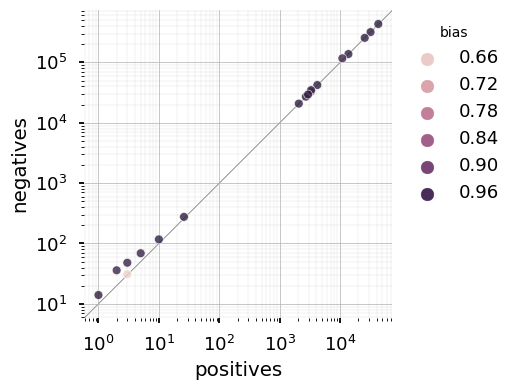

In [410]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_bias(train_ppis, train_negs, train_bias, c.ratio)
fig.savefig('train_bias.png')

#### degrees
Evaluate how close the real ratio of negative : positive interactions per protein is to our target ratio

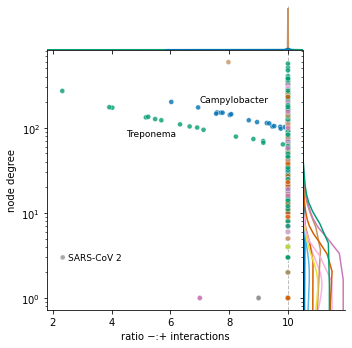

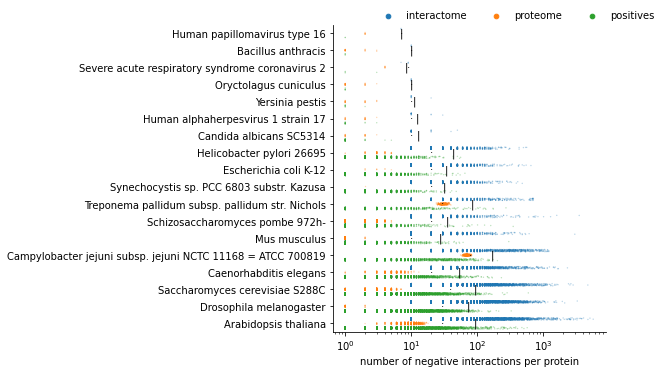

In [91]:
with mpl.rc_context({'figure.dpi': 72}):
    fig, fig2, df, tnsp = plot_ratio_degree(train_ppis, train_negs, c.ratio, taxonomy)
ax = fig.axes[0]
ax.set(xlim=(1.8, 10.5))
ax.annotate('SARS-CoV 2', xy=(2.5, 2.8), size=9)  # 2697049
ax.annotate('Treponema', xy=(4.5, 80), size=9)  # 243276
ax.annotate('Campylobacter', xy=(7, 200), size=9)  # 192222
for sfx in ['png', 'pdf', 'svg']:
    fig.savefig(f'train_ratio_degree.{sfx}', transparent=False, dpi=300)
    fig2.savefig(f'train_negative_degree.{sfx}', transparent=False, dpi=300)

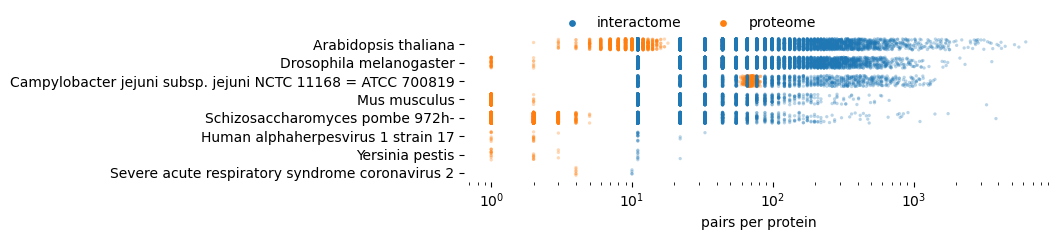

In [338]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degrees_wide(train_ppis, train_negs, taxonomy, False, [3702, 7227, 284812, 10090, 192222, 10299, 632, 2697049])
#fg.savefig('train_degree_wide.svg')

In [ ]:
if 559292 in c.train_species:
    with mpl.rc_context({'figure.dpi': 64}):
        tt_ppis, tt_negs, tt_bias, _ = make_negatives(
            train.loc[train.species == 559292].copy(), c, train_proteome)

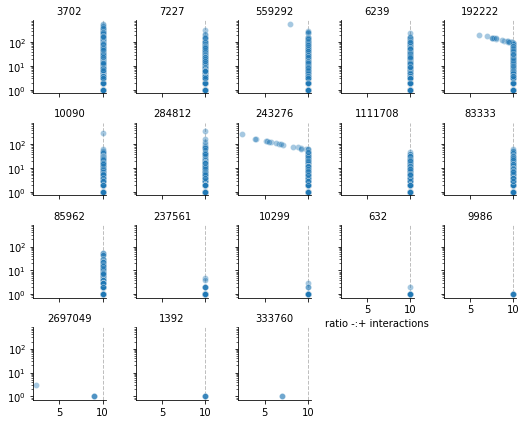

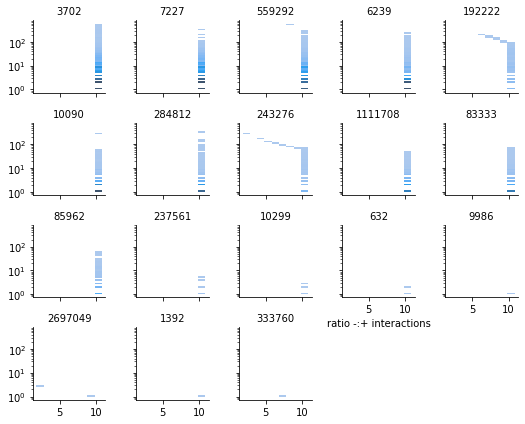

In [92]:
order = (taxonomy.loc[taxonomy.species.isin(train.species)]
             .sort_values(by='n_ppis')['species'][::-1])
with mpl.rc_context({'figure.dpi': 72}):
    g, h = plot_ratio_grids(df, order, c.ratio)

In [93]:
desc = (df  #.loc[df.degree <= 3]
        .groupby('species')
        .describe()
        ['ratio']
        .sort_values(by='count')
        .round(2)
        .convert_dtypes()
        )
desc

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
333760,2,7.0,0.0,7.0,7.0,7,7,7
2697049,4,7.33,3.33,2.33,7.33,9,9,9
1392,4,10.0,0.0,10.0,10.0,10,10,10
9986,6,10.0,0.0,10.0,10.0,10,10,10
632,9,10.0,0.0,10.0,10.0,10,10,10
10299,16,10.0,0.0,10.0,10.0,10,10,10
237561,40,10.0,0.0,10.0,10.0,10,10,10
243276,684,9.92,0.62,2.32,10.0,10,10,10
85962,939,10.0,0.0,10.0,10.0,10,10,10


#### save
The PPIs are easy:

In [94]:
train_all = pd.concat((train_ppis, train_negs))
train_all.to_csv(c.train_tsv, sep='\t', header=True, index=False)
c.train_size = len(train_all)
c.train_size, c.train_tsv

(1592405, PosixPath('apid_train.tsv'))

But update the set of sequences with the added SwissProt proteins.

In [95]:
assert not set(np.unique(train_ppis.iloc[:, [0, 1]])) - train_seqs.keys()

In [96]:
train_extra = get_proteome_seqs(train_proteome, train_seqs, train_negs)
_ = SeqIO.write(values_sorted_by_key(train_extra),
                c.pp / 'train_extra.fasta', 'fasta')
train_seqs.update(train_extra)
c.train_extra = len(train_extra)
c.train_extra

5525

In [97]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_fasta, 'fasta')
len(train_seqs), c.train_fasta

(44954, PosixPath('apid_train.fasta'))

In [98]:
assert len(train_all), len(train_seqs) == shrink_both_ways(
    train_all.copy(), train_seqs.copy())

## APID validation
#### generate negatives
The `val` DataFrame is not up-to-date, use the contents of `val_rr_tsv` and `val_rr_fasta` instead!

In [99]:
val = pd.read_csv(c.val_rr_tsv, sep='\t', header=0)
val_seqs = SeqIO.to_dict(SeqIO.parse(c.val_rr_fasta, 'fasta'))
len(val), len(val_seqs)

(2284, 1746)

In [100]:
set(val.species)

{7955, 8355, 9031, 9913, 10116, 10377, 36329, 37296, 39947, 224308}

In [101]:
val_proteome = read_json(c.val_proteome)

In [102]:
with mpl.rc_context({'figure.dpi': 64}):
    val_ppis, val_negs, val_bias, _ = make_negatives(val, c, val_proteome)

sampling negatives per species! aim for 22840


9031: 334it [00:00, 12120.27it/s]                                                    

9031: CRC-2F1A587F4D7A2E88:CRC-EDEE0A97EAB05D38:CRC-2E8E79AD2E03C5A4:CRC-B81841D63734B7AA:CRC-F8C8331783FE3889:CRC-A69049EAD420C525:CRC-2A59245C69ACE7E9:CRC-55F05BD77CC86467:CRC-EC5404CE7A32E7AD:CRC-188586295E2CA5BA:CRC-45A764C4DE9C2F99:CRC-6AD621489599FB49


8355: 276it [00:00, 7523.61it/s]                                                     


7955: 602it [00:00, 8400.16it/s]                                                     


8355: CRC-55FF706A536416D8:CRC-7908BF460402AD95:CRC-DBF738CEB85CAFD7:CRC-A542AF01465EB9C2:CRC-02F2BD22964B5F28:CRC-BD3B06542FA1B8F2:CRC-2EA139D5FD5C8CAB:CRC-81D0A45C76A24694:CRC-217A9E2C82A100A8:CRC-7852F9D467FF4217:CRC-93A6478A3786D7B7:CRC-6EDC3EB7BE545E12:CRC-4F32610D8805C291:CRC-37155FEBD1AC0CB9:CRC-81989B85C563B515


10377:   0%|                                                 | 0/180 [00:00<?, ?it/s]

7955: CRC-082342327D4AED25:CRC-A1445DF3446D2D53:CRC-B476D1F04443AA0E:CRC-BC2F3F158ABB60AC:CRC-BC3972635423A07C:CRC-C282CD3CAB7961CA:CRC-69ADBDA85DE8031C:CRC-09CDBA44C5005903:CRC-E3B2407785ED6C52:CRC-8E5B3EF1177EECC3:CRC-E993A8F3536E8390:CRC-D1D5F57F2EC202E4:CRC-E271E27068A33B77:CRC-2977890AB875EFE3:CRC-C43E420F706EBB7B:CRC-6805CD0D849A6E25:CRC-2CA8CADA2BEA00F1:CRC-48EE6F6C41004315:CRC-5442F499BDCF06C4:CRC-E021EBBAB31E0002:CRC-385FEF68311374FF:CRC-479C4A0E8C8CE1E6:CRC-598CD993676483B9:CRC-0ED5B9850EBFB222:CRC-D01D61037785D4BF:CRC-69A428866A5A597A:CRC-731D3848F3D08142:CRC-60B2888F16A1C225:CRC-52EDD3FB9279DF55:CRC-434B7B0A820A6B63:CRC-14033C8AE600655F:CRC-40435023A870BF44:CRC-7253379F4A5FEF93:CRC-0BCDAC1B58F3D5B2:CRC-BE4F059AE18C5038:CRC-43D67BBE9AD0AAA3:CRC-8B30BCCD33EDC562:CRC-9144DE2D0EED8192:CRC-45021C9F47B3E2F3:CRC-59768A7F4F36C680:CRC-CF51CD55CA4285DD:CRC-BDD82C1118FB0B52:CRC-EF06C9BDFE9A6485:CRC-326770AC45B36C90:CRC-523B2CCA0D383A20:CRC-42313D45C7707F8B:CRC-2FB58808094AE0B2:CRC-18B

10377: 232it [00:00, 10837.99it/s]                                                   
37296:   0%|                                                 | 0/700 [00:00<?, ?it/s]

10377: CRC-97A4CCDB598A09F1:CRC-6843A9A0A0CDD794:CRC-BDB101894C5980F5:CRC-E6E65BB078FBD9AD:CRC-BEA42273B6CA6260:CRC-6C5DBFC55F2FF729:CRC-7F3D55D79F1F0196:CRC-C1BD8D0FA32DD99E:CRC-7D8D7B9E67064BAB:CRC-A04A22C360014A8B:CRC-241ECF46F613A68B:CRC-9F5140CFF7318B85:CRC-CA5A24D1EA28758E:CRC-FC2D355F8A389708:CRC-4B89429FC5E4DD03:CRC-DAB605ED00F1A656:CRC-79B3206D8DEB7337:CRC-1FF730E3775BDB63:CRC-1E19446E857DB8A3:CRC-473BF0BDFB7F0637:CRC-283D5258031A16D6:CRC-05F8A4719F604D03:CRC-48D6CED09331119E:CRC-6E5C25623D371EF1:CRC-F62AA52CEA581AC3:CRC-59605D622EF6FC91:CRC-F0292CEA80626C96:CRC-C3F33A253B959ADA:CRC-58D1DC644EB84BE6:CRC-0750141CBCAC52C9:CRC-73C90EFF4B863525:CRC-3FA433CE1EB04461:CRC-B3D085D233AF6251:CRC-6FDCF63D324BD13B:CRC-F87541F6CEC26D74:CRC-4D161653E16FC341:CRC-B5B7DF0593FADB08:CRC-D83E6DFE09EC7B5A


9913: 1448it [00:00, 10027.97it/s]                                                   


9913: CRC-F5F078F7CE885D46:CRC-BB4EE6FD8F64D729:CRC-4FD32FE4419AE0A2:CRC-7E3308E9B8A703B3:CRC-2A0136AC143958DB:CRC-5077BC2F7A21147A:CRC-CAD7390296CA2CFA:CRC-01C2C2DC4D9E0C7A:CRC-C3FDD1A29EB75848:CRC-AD90FB5906FCD159:CRC-B308F165E7300ADC:CRC-0CC509544B7AC080:CRC-DB90947CCA38517D:CRC-128A8223499DE6FC:CRC-363A219DB5BBFC4B:CRC-D273E39309C49771:CRC-8775EBDA815FD9DA:CRC-A3802FB60D438A53:CRC-CD9AC68D0119CFC3:CRC-7CB144A630ACD48A:CRC-25D6D0E2783071A3:CRC-7062F2291728EA9D:CRC-FED607E2BA6FE77B:CRC-3E3CC7C36AF5E8B1:CRC-63C5F2BDFDFA6BA4:CRC-2D5F275382061534:CRC-63D2B28F69D33587:CRC-F6DE1C736FCC9CF0:CRC-9D31D695CCF25802:CRC-ECF0B18B88B4271C:CRC-DFADD4C2331709AD:CRC-B24B6CF68084B2E6:CRC-BE5605ED3E479E23:CRC-FC2117674F51C230:CRC-73A22E23A68F9927:CRC-6B2172A1177D97FC:CRC-8223D1647E3708E0:CRC-D8004237F684D4B8:CRC-C3CBF2C763A91BB8:CRC-4C4F1F67CC50BDEB:CRC-5DD80515B3AA657D:CRC-A0F000B9BA2EC341:CRC-0AA0B0F28C59482B:CRC-E879BBD942E8334C:CRC-6DE579F89AFD94F0:CRC-0525F7C775266B87:CRC-A3E0E71E2A923060:CRC-736

37296: 1166it [00:00, 12709.58it/s]                                                  


37296: CRC-5A13A3DB1902C306:CRC-912C991D447F88C3:CRC-9B591DA04264B00B:CRC-2D1107D9066C873D:CRC-7C45FA331C0620B4:CRC-7BCC63441CB66385:CRC-9A87BB553218C838:CRC-9492017B2BCA7076:CRC-CE3399C0C1D143D9:CRC-8C4D7FE5ED30E732:CRC-03C5758684D43F85:CRC-B086BCEDE0F5F5F7:CRC-DFB0C25B90D4B407:CRC-BCF82E45EAE9273E:CRC-3C6A4E48FD57521A:CRC-22B0B2400584948D:CRC-746EF211B4C2ED82:CRC-77A1479AB47CF8E8:CRC-0DBAE5A8B7A2E6AE:CRC-AA3E459EA035357F:CRC-C2A522482C7D4534:CRC-589B2617E3900D80:CRC-F38E620E8BE7C413:CRC-5E78A3F11D1DD246:CRC-177898B9EE6367CB:CRC-E6ECB720867BBEC5:CRC-E668D912BB592265:CRC-8BF83AAC07CA232F:CRC-189A7D9FCEDD91E3:CRC-E3433382DED5A4D5:CRC-84E2C006FB95D720:CRC-EA43E3484FFF9B23:CRC-15EF6BAE9E790926:CRC-4E56FD2AE070237E:CRC-37CFE147EAE45371:CRC-B1F67A30DE9AF0E4:CRC-0CDBD828C1E0AB86


39947: 1740it [00:00, 9446.81it/s]                                                   


39947: CRC-BB83CDA01C9D9D70:CRC-537E075A4C573572:CRC-B2C34A44BAA985A3:CRC-81400FED31799167:CRC-31B0045D683FBF43:CRC-AAE15A9EFCABA002:CRC-B9E738A5AF21EBAC:CRC-E49AEB2D89F16399:CRC-13A5B8466BD56643:CRC-D14872ADB0ED595D:CRC-05D9D836899012F1:CRC-AA7324846245378E:CRC-9C0260D8384ADEEE:CRC-864D02FF3C5DDB93:CRC-F09FE56B9582B57D:CRC-18F2C829C12D9B7C:CRC-EE9C73C74DB6B338:CRC-7F915A1012F51F4F:CRC-B0991FA11DA8799C:CRC-4DA25594A011BEE4:CRC-F1B57D1CE595FB9E:CRC-9A2C0BD91AFC5835:CRC-0755FAD060AEFDA8:CRC-46730EE36AC9F342:CRC-7216D1D425745554:CRC-48E68B0D577E9C55:CRC-E1E1852050230554:CRC-755996C6D60229A0


10116: 5484it [00:00, 9059.31it/s]                                                   
224308:  17%|█████▋                           | 3650/21040 [00:00<00:02, 7489.53it/s]

10116: CRC-7BEE1AB539DCA463:CRC-F33151A6E68A07F6:CRC-DE0DA795C64D0161:CRC-8E5141444F5DEA90:CRC-17F6795B243632DC:CRC-5B648954D0E1847E:CRC-03021BC9FFE75646:CRC-5F635A5CD4C5686D:CRC-C3B8CFA206942B2C:CRC-AC43F7DD8CA4643A:CRC-B3361D4E6FF77FC4:CRC-4CF09EE9B99ADEC8:CRC-78EFF3E1C76EDF39:CRC-7BB0ED189744C6BC:CRC-76F5089969408638:CRC-F409DB3CCC5A01C3:CRC-530DF971EB689EFD:CRC-481B24B73E25E7FF:CRC-F9813A823D3E1F53:CRC-F139BAFC510B9ED1:CRC-E2A4EE95F09AEE84:CRC-8499170B94C7DC35:CRC-3C3496A04C82F9EE:CRC-7A674DDE7F2759EB:CRC-E4D6ADC56B61A053:CRC-881450A58ACBAC76:CRC-93DC9F1886A3D0C1:CRC-7084900CA2B90BDF:CRC-BED2A8C2F5BC9DC9:CRC-F91EE00BC52AD32B:CRC-1D03127D9C530F63:CRC-7EC4F7A491B913D0:CRC-2DBF86925B016BA3:CRC-8FE970A47D13F97F:CRC-3829665B1BE336E6:CRC-4EE09E59CBC8CE43:CRC-CB2D3CB651D45270:CRC-D7D27D653C9741BA:CRC-A79DFC9B04A8BB9A:CRC-1C66874DB94E6F6A:CRC-1126B57BA7A6FDAF:CRC-99B8CAE6695FFF5B:CRC-1D99E61243C5BFDB:CRC-A6084F290F0BC88A:CRC-3CE8F3651B1616EC:CRC-488F893571E3C11D:CRC-C89E3FCE0C0EE92E:CRC-38

36329: 14940it [00:01, 7487.87it/s]                                                  


36329: CRC-DE3A7B87E2F9E99D:CRC-F1425E7F2A209CAC:CRC-9237374098CD6C8E:CRC-4C49F6E056358798:CRC-288C44EA4FB8C2D4:CRC-F60839DCFDAB9EB5:CRC-C1F586A4B342EC06:CRC-8FFB8329B814C074:CRC-DDC82A31B917248D:CRC-38DC1F8DD3058CC3:CRC-583926B5FFB53FCA


224308: 25100it [00:03, 7728.11it/s]                                                 


224308: CRC-B3968089A6049421:CRC-CD79B13B956B000F:CRC-35F73AF8D94EE40B:CRC-D8A54B4DEAF1E94E:CRC-68F1007CC9D8D157:CRC-BBE3E698CD46E6ED:CRC-9AF632343AD1B083:CRC-E2580113272A9165:CRC-091863F3BF8566CA:CRC-B93FC0528C5B49F4:CRC-E1BD5EA5231DED2C:CRC-16F36579735EF7B4:CRC-70C1C696389C8834:CRC-2CD0B5A26F411D07:CRC-4E14E6D97FF4CFAC:CRC-A943DDFEAB67BD01:CRC-879D115A0B089650:CRC-104A3651F7FC7962:CRC-DA3247604BC8CCAA:CRC-7A65B1BFB99C2E93:CRC-0A1B306CEB39801A:CRC-EAB8F41257BA8885:CRC-6D6E255AA1021456:CRC-B835335D8AF927B3:CRC-6D8FE24B1ED9F88E:CRC-7E54E105B86AFF99:CRC-371B9B3410E61AD3:CRC-868DDDC0B03DCEAF:CRC-302BABF95065584A:CRC-BB7177EB27924D36:CRC-746840393001FDE9:CRC-FFC45073DF23E72D:CRC-0D6DEC23FBBD8232:CRC-CE74FAC2C061237B:CRC-4AE27C3BAEBFC7EE:CRC-2786FEE1DBDFD2A2:CRC-E316DFB28A013555:CRC-8641BF1932666C38:CRC-05739D0B768A8644:CRC-8BA7DDC103C1DFF5:CRC-B07F532D9AAE0869:CRC-207F04CC141DB3E2:CRC-9D3B4A34623248D5:CRC-4A93A6A4500C179A:CRC-F1D76CCE914B29A5:CRC-CF028BD1A3F0B6E0:CRC-A4BB14A14ECF4A12:CRC-C

25543 negatives with overall 0.999 and average per-species bias of 0.989±0.029 (std)

#### bias

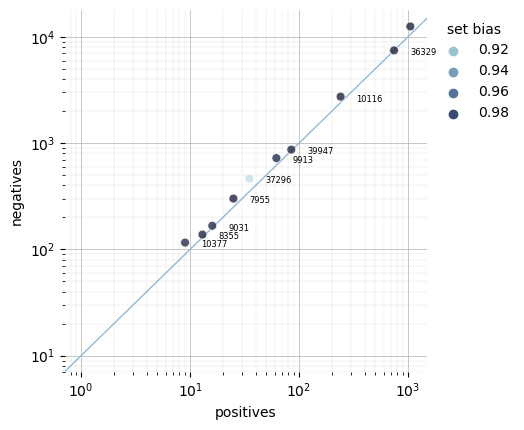

In [103]:
if type(val_bias) == np.float64:
    c.val_bias = val_bias
else:
    assert type(val_bias) == pd.DataFrame
    c.val_bias = val_bias.set_index('species').to_dict()['bias']

    with mpl.rc_context({'figure.dpi': 100}):
        fig = plot_bias(val_ppis, val_negs, val_bias, c.ratio)
    # fig.savefig('val_bias.png', transparent=False)

In [104]:
c.val_bias

{7955: 0.9993580300030909,
 8355: 0.9981452408491638,
 9031: 0.9965440492134408,
 9913: 0.9968425395586364,
 10116: 0.9998763269080935,
 10377: 0.9945247446260248,
 36329: 0.9999585445768,
 37296: 0.9023225397426413,
 39947: 0.9991107593160174,
 224308: 0.9996385721394987}

#### degrees

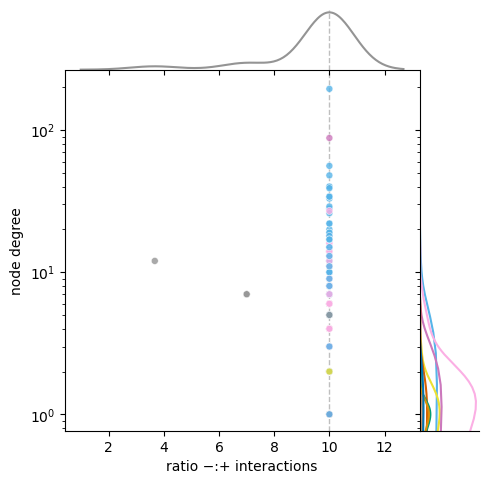

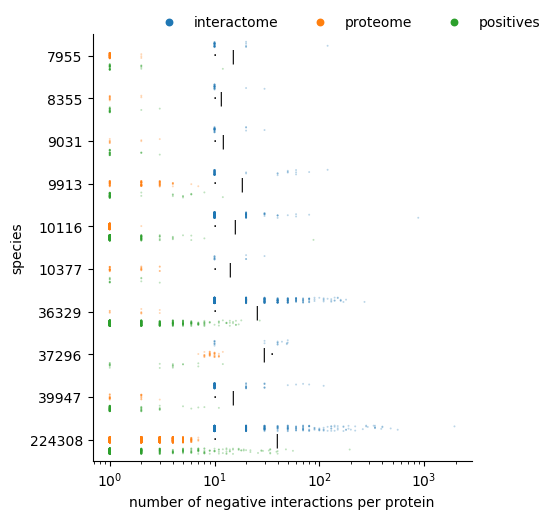

In [105]:
with mpl.rc_context({'figure.dpi': 100}):
    fig, fig2, vdf, vnsp = plot_ratio_degree(val_ppis, val_negs, c.ratio)
for sfx in ['png', 'pdf', 'svg']:
    fig.savefig(f'val_ratio_degree.{sfx}', transparent=False, dpi=300)
    fig2.savefig(f'val_negative_degree.{sfx}', transparent=False, dpi=300)

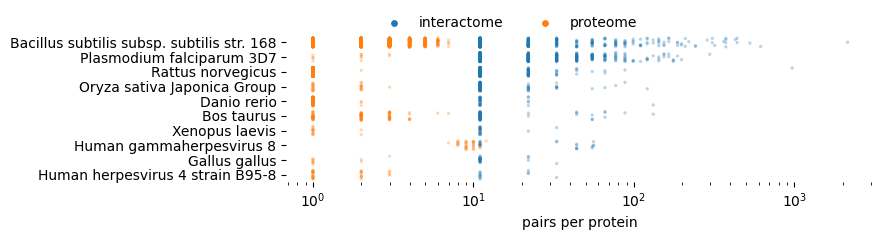

In [340]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degrees_wide(val_ppis, val_negs, taxonomy)
#fg.savefig('val_degree_wide.svg')

Are we running out of extra proteins again?

In [106]:
vdf.loc[vdf.ratio != c.ratio]

,crc_hash,degree,ratio,species
518,CRC-468877D25B4B0173,7,7.000000,37296
1368,CRC-C34E41D6B181DAFB,7,7.000000,37296
1711,CRC-F8F5876EFDA2BB35,12,3.666667,37296


37296: 35 positives, aim for 350 negatives


37296: 1166it [00:00, 11714.92it/s]                                                  

37296: 117/350 interactome negatives
37296: need 113 extra proteins for 12 hubs; select 37 from 37/37 (new/available) SwissProt proteins. Try to create 466 interactions, ideally 3.5 per protein.
37296: CRC-5A13A3DB1902C306:CRC-912C991D447F88C3:CRC-9B591DA04264B00B:CRC-2D1107D9066C873D:CRC-7C45FA331C0620B4:CRC-7BCC63441CB66385:CRC-9A87BB553218C838:CRC-9492017B2BCA7076:CRC-CE3399C0C1D143D9:CRC-8C4D7FE5ED30E732:CRC-03C5758684D43F85:CRC-B086BCEDE0F5F5F7:CRC-DFB0C25B90D4B407:CRC-BCF82E45EAE9273E:CRC-3C6A4E48FD57521A:CRC-22B0B2400584948D:CRC-746EF211B4C2ED82:CRC-77A1479AB47CF8E8:CRC-0DBAE5A8B7A2E6AE:CRC-AA3E459EA035357F:CRC-C2A522482C7D4534:CRC-589B2617E3900D80:CRC-F38E620E8BE7C413:CRC-5E78A3F11D1DD246:CRC-177898B9EE6367CB:CRC-E6ECB720867BBEC5:CRC-E668D912BB592265:CRC-8BF83AAC07CA232F:CRC-189A7D9FCEDD91E3:CRC-E3433382DED5A4D5:CRC-84E2C006FB95D720:CRC-EA43E3484FFF9B23:CRC-15EF6BAE9E790926:CRC-4E56FD2AE070237E:CRC-37CFE147EAE45371:CRC-B1F67A30DE9AF0E4:CRC-0CDBD828C1E0AB86
proteome interactions

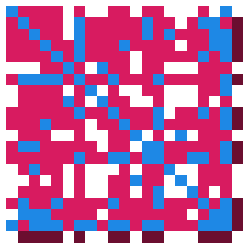

In [107]:
if 37296 in c.val_species:
    with mpl.rc_context({'figure.dpi': 64}):
        v_ppis, v_negs, v_bias, _ = make_negatives(
            val.loc[val.species == 37296].copy(), c, val_proteome)

Yes we are running out of extra (SwissProt) proteins again!

#### save
First, save the PPIs as a `TSV`. This is straightforward, but we will overwrite that file right after clustering the `FASTA`.

In [108]:
val_all = pd.concat((val_ppis, val_negs))
val_all.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_size = len(val_all)
c.val_size, c.val_tsv

(27827, PosixPath('apid_validation.tsv'))

In [109]:
assert not set(np.unique(val_ppis.iloc[:, [0, 1]])) - val_seqs.keys()

In [110]:
val_extra = get_proteome_seqs(val_proteome, val_seqs, val_negs)
_ = SeqIO.write(values_sorted_by_key(val_extra),
                c.pp / 'val_extra.fasta', 'fasta')
c.val_extra = len(val_extra)
c.val_extra, len(val_seqs)

(2630, 1746)

In [111]:
val_seqs.update(val_extra)

In [112]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_fasta, 'fasta')
len(val_seqs), c.val_fasta

(4376, PosixPath('apid_validation.fasta'))

In [113]:
assert len(val_all), len(val_seqs) == shrink_both_ways(
    val_all.copy(), val_seqs.copy())

#### cluster against train
Clustering the `APID` validation set against the `APID` train set gives us **C1-3** labels for the validation set.

In [114]:
run_uniqueprot2D(c.val_fasta, c.train_fasta, c.val_c3_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json apid_validation.fasta apid_train.fasta apid/apid_validation_c3.fasta
using temporary directory apid_validationk6z3lrqj
extract hvals from alignments: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]
 3209/4376::44954 non-redundant in apid_validation.fasta against apid_train.fasta written to apid/apid_validation_c3.fasta


#### label PPIs

In [115]:
val_pairs = make_c_classes(c.val_tsv, c.val_c3_fasta, c.val_fasta)

#### class sizes

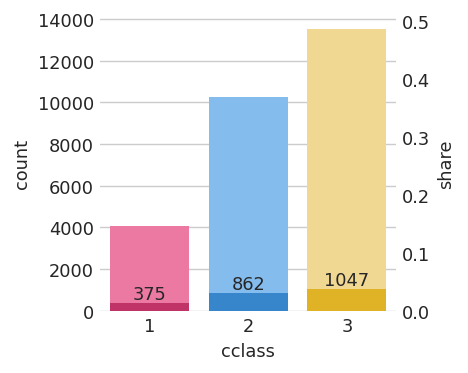

In [116]:
with mpl.rc_context({'figure.dpi': 128}):
    fig, c.val_sizes = plot_c_classes(val_pairs)
for sfx in ['png', 'svg']:
    fig.savefig(f'val_cclasses.{sfx}', transparent=False, dpi=300)

In [122]:
# sizes of the sets of positives per species
dict(val_ppis.species.value_counts())

{224308: 1052,
 36329: 746,
 10116: 241,
 39947: 85,
 9913: 62,
 37296: 35,
 7955: 25,
 9031: 16,
 8355: 13,
 10377: 9}

#### save

In [123]:
if not (bak := c.val_tsv.with_suffix('.tsv.bak')).is_file():
    shutil.move(c.val_tsv, bak)
val_pairs.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_tsv

PosixPath('apid_validation.tsv')

In [124]:
with Path(f'cfg.json').open('w') as json_file:
    json_file.write(c.to_json(indent=2))

## HuRI test
#### generate negatives
Read in the files first ...

In [125]:
test = pd.read_csv(c.test_rr_tsv, sep='\t', header=0)
test_seqs = SeqIO.to_dict(SeqIO.parse(c.test_rr_fasta, 'fasta'))
len(test), len(test_seqs)

(23150, 5138)

In [126]:
set(test.species)

{9606}

In [127]:
test_proteome = read_json(c.test_proteome)
len(test_proteome[9606])

10360

9606: 23150 positives, aim for 231500 negatives


9606: 467112it [04:03, 1916.26it/s]                                                  


9606: 229444/231500 interactome negatives
9606: need 375 extra proteins for 99 hubs; select 457 from 10358/10360 (new/available) SwissProt proteins. Try to create 4112 interactions, ideally 9.011288439081355 per protein.
9606: CRC-68A16430DCEA5F13:CRC-52F8B7BE28A175F3:CRC-8AE80E6B823635DB:CRC-A01C5895FD6C804F:CRC-B2B9A88B8FBA1126:CRC-F88FF61DD242E818:CRC-CFE3DBF343589BD4:CRC-3E5B3CD6891F72C2:CRC-30A2855DDCDFE0A4:CRC-2CF5DB1741A2E64E:CRC-9063D716A316FE89:CRC-8EE498C8AA1DE8D6:CRC-E57472CE0D86405D:CRC-814174330F577D5E:CRC-8FC5243F9169617F:CRC-2D88DEFED0EA0777:CRC-752EFB2FCC29B8E8:CRC-46EB6C11ABFD5E8F:CRC-3F30748230911130:CRC-D169B0C6892DCC81:CRC-25909A0851445F83:CRC-98880A3AA9A9EEDE:CRC-2EA8357355F70142:CRC-257A2B22C795308F:CRC-4EA93961DB55703B:CRC-7D8BA6204012B7FF:CRC-AB9EF3B9E8230053:CRC-5F3C90817EC11BA5:CRC-0B165C6BAE5A49CF:CRC-40AA14EF186A6009:CRC-08402189C9B4E329:CRC-B36B81827D219F9E:CRC-AA3CB0204AC1693E:CRC-492C00A4139581EA:CRC-A588E089810F751C:CRC-BFEA331DDD188384:CRC-B3536D012A127

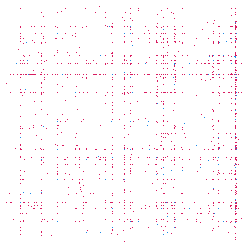

In [128]:
with mpl.rc_context({'figure.dpi': 64}):
    test_ppis, test_negatives, c.test_bias, _ = make_negatives(
        test, c, test_proteome)

9606: got 233556 negatives with bias 1.000

In [129]:
test_ppis.head()

,hash_A,hash_B,species,label
0,CRC-000037AE195F7A9D,CRC-82152E496B924EEC,9606,1
1,CRC-000624825E507385,CRC-C116E348E8B7AD2B,9606,1
2,CRC-000624825E507385,CRC-D7C7F6F2CD922775,9606,1
3,CRC-0012F055C7F2A233,CRC-E40668099ED25828,9606,1
4,CRC-001576EA78C61C85,CRC-00AC1C2A0AC82253,9606,1


In [130]:
test_negatives.head()

,hash_A,hash_B,species,label
0,CRC-000037AE195F7A9D,CRC-2D58B9BA76464EF0,9606,0
1,CRC-000037AE195F7A9D,CRC-35BA76D3668E69A3,9606,0
2,CRC-000037AE195F7A9D,CRC-47C45EA0BB722E09,9606,0
3,CRC-000037AE195F7A9D,CRC-4BF7A754AB1ED7CF,9606,0
4,CRC-000037AE195F7A9D,CRC-5D7DEE59D7DDB9E0,9606,0


#### bias
As the test set contains only single species, this is just a number

In [131]:
c.test_bias

0.999889126756907

#### degrees

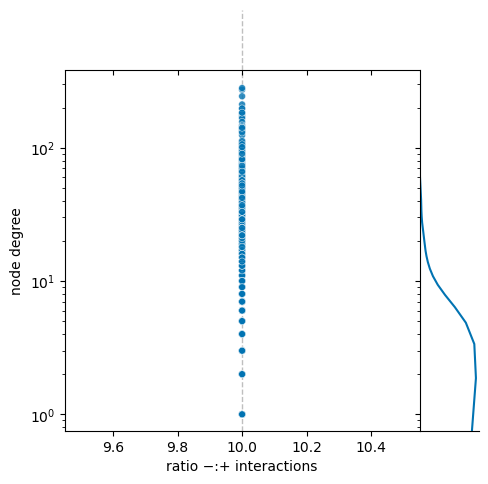

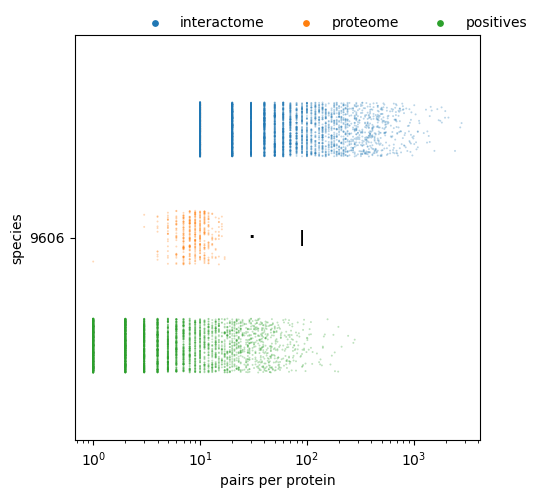

In [333]:
with mpl.rc_context({'figure.dpi': 100}):
    fig, fig2, tdf, tnsp = plot_ratio_degree(test_ppis, test_negatives, c.ratio)
for sfx in ['png', 'pdf', 'svg']:
#    fig.savefig(f'test_ratio_degree.{sfx}', transparent=False, dpi=300)
    fig2.savefig(f'test_negative_degree.{sfx}', transparent=False, dpi=300)

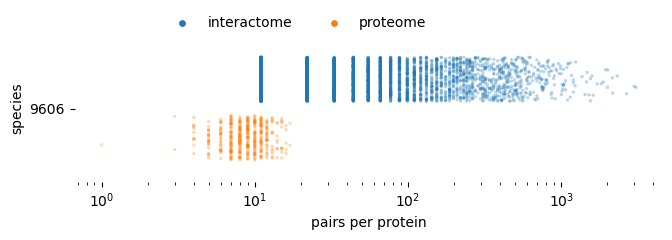

In [344]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degrees_wide(test_ppis, test_negatives, None, True)
#fg.savefig('test_degree_wide.svg')

In [133]:
tdf.loc[tdf.ratio != c.ratio]

,crc_hash,degree,ratio,species


#### save
First, save the PPIs as a `TSV`. This is straightforward, but we will overwrite that file right after clustering the `FASTA`.

In [134]:
test_all = pd.concat((test_ppis, test_negatives))
test_all.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_size = len(test_all)
c.test_size, c.test_tsv

(256706, PosixPath('huri_test.tsv'))

In [135]:
assert not set(np.unique(test_ppis.iloc[:, [0, 1]])) - test_seqs.keys()

In [136]:
test_extra = get_proteome_seqs(test_proteome, test_seqs, test_negatives)
_ = SeqIO.write(values_sorted_by_key(test_extra),
                c.pp / 'test_extra.fasta', 'fasta')
c.test_extra = len(test_extra)
c.test_extra, len(test_seqs)

(457, 5138)

In [137]:
test_seqs.update(test_extra)

In [138]:
_ = SeqIO.write(values_sorted_by_key(test_seqs), c.test_fasta, 'fasta')
len(test_seqs), c.test_fasta

(5595, PosixPath('huri_test.fasta'))

In [139]:
assert len(test_all), len(test_seqs) == shrink_both_ways(
    test_all.copy(), test_seqs.copy())

#### cluster against train
Clustering the `HuRI` test set against the `APID` train set gives us **C1-3** labels for the test set.

In [140]:
run_uniqueprot2D(c.test_fasta, c.train_fasta, c.test_c3_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json huri_test.fasta apid_train.fasta huri/huri_test_c3.fasta
using temporary directory huri_testh1n2th17
extract hvals from alignments: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]
 2987/5595::44954 non-redundant in huri_test.fasta against apid_train.fasta written to huri/huri_test_c3.fasta


2983/5595::44947

#### label PPIs

In [141]:
test_pairs = make_c_classes(c.test_tsv, c.test_c3_fasta, c.test_fasta)

#### class sizes

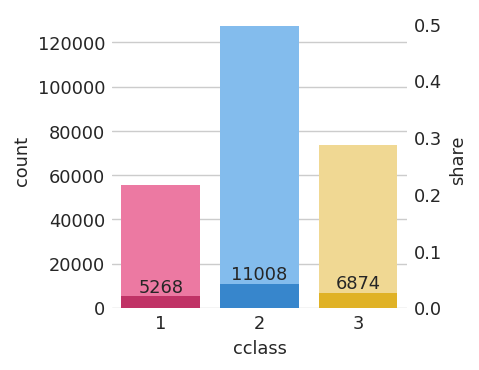

In [143]:
with mpl.rc_context({'figure.dpi': 128}):
    fig, c.test_sizes = plot_c_classes(test_pairs)
for sfx in ['png', 'svg']:
    fig.savefig(f'test_cclasses.{sfx}', transparent=False, dpi=300)

#### save

In [144]:
if not (bak := c.test_tsv.with_suffix('.tsv.bak')).is_file():
    shutil.move(c.test_tsv, bak)
test_pairs.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_tsv

PosixPath('huri_test.tsv')

---

In [145]:
with Path(f'cfg.json').open('w') as json_file:
    json_file.write(c.to_json(indent=2))
print(c.to_json(indent=2))

{
  "keep_human": false,
  "keep_interspecies": false,
  "accept_homodimers": false,
  "add_proteomes": true,
  "slurm": true,
  "slurm_node_limit": 15,
  "rostclust": "/home/k/kaindll/mambaforge/envs/ppi/bin/rostclust",
  "cwd": "/home/k/kaindll/ppi/data/ppi_dataset/results/7080",
  "ap": "apid",
  "hp": "huri",
  "qp": "apid_q1",
  "pp": "swissprot",
  "min_seq_len": 50,
  "max_seq_len": 1500,
  "hval_config": {
    "shortAlignmentLen": 50,
    "longSeqLen": 180,
    "reduceRandomAlign": false,
    "clusterThreshold": 20
  },
  "hval_config_path": "hval_config.json",
  "seed": 42,
  "ratio": 10.0,
  "strategy": 1,
  "val_set_size": 0.1,
  "val_species": [
    8355,
    10116,
    9031,
    10377,
    36329,
    39947,
    37296,
    7955,
    224308,
    9913
  ],
  "train_species": [
    333760,
    1111708,
    9986,
    2697049,
    83333,
    10299,
    10090,
    85962,
    243276,
    284812,
    1392,
    3702,
    632,
    237561,
    7227,
    559292,
    192222,
    6239
  

In [411]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)
importlib.reload(proteome)

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

#### Re-plot the dataset bias

In [407]:
dscript_dir = Path('dscript')
bias = dict()
dts = list()
for tsv in dscript_dir.glob('*.tsv'):
    dt = pd.read_csv(tsv, sep='\t', header=None, names=['A', 'B', 'label'])
    dt['species'] = tsv.stem
    dts.append(dt)
    bias[tsv.stem] = estimate_bias(dt)
bias = pd.DataFrame(bias).T.reset_index().rename(
    columns={'index': 'species', 0: 'bias', 1: 'p'})[['species', 'bias']]
dscript_ppis = pd.concat(dts).convert_dtypes()
dscript_negs, dscript_ppis = [t[1] for t in dscript_ppis.groupby('label')]

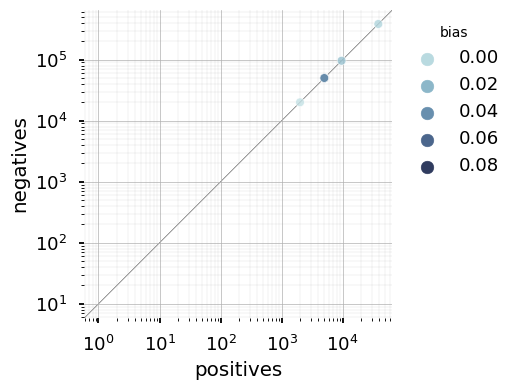

In [412]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_bias(dscript_ppis, dscript_negs, bias, c.ratio, pal=True)
fig.savefig('dataset_bias_dscript.svg')

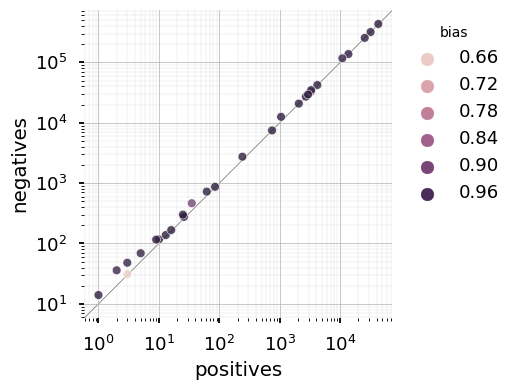

In [409]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_bias(pd.concat((train_ppis, val_ppis, test_ppis)), 
                    pd.concat((train_negs, val_negs, test_negatives)), 
                    pd.concat((train_bias, val_bias)), c.ratio)
fig.savefig('dataset_bias.svg')

---

DeprecationWarning: Proteins by themselves do not have a C123 class but are assigned one here! PPIs belong to a class.

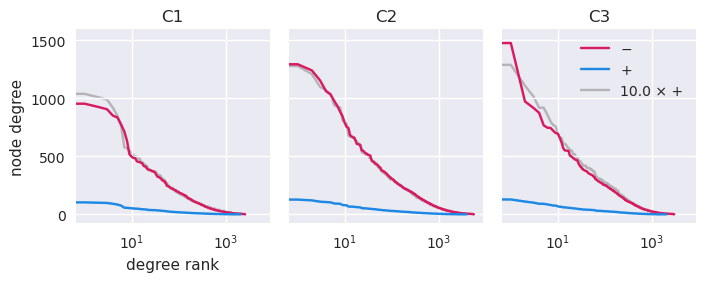

In [147]:
_ = plot_test_ratios(test_pairs, c.ratio)